In [1]:
import oss2
import os
import numpy as np
import pandas as pd
from odps import ODPS
from odps.df import DataFrame
import datetime
import time
import matplotlib.pyplot as plt
import warnings
import pickle
warnings.filterwarnings('ignore')

In [2]:
# 公共OSS AK
bucket_name = 'sf-2023'
oss_endpoint = 'http://oss-cn-guangzhou-nfdw-d01-a.pdcc-cloud-inc.cn'
AK = 'wbr4Y7IjXopW7CWZ'
AKS = 'reP1eCeahBC7U9w0i5rhQU9oGgS0NA'

# 广西AK
AK_GX = 'MBs3yHviVlKIY3gh'
AKS_GX = 'wUvWZOnGTtWVVir65A3ogIfOKSkHIB'
NAME = 'sf_2023_chenquanqi'
endpoint = 'http://service.cn-guangzhou-nfdw-d01.odps.pdcc-cloud-inc.cn/api'

# 算法使用参数
oid_list = ['15481140756807681','15481140756873217','15481140756938753','15481140830863361','15481140766113793',
            '15481140766179329','15481140766244865','15481140766310401','15481140757266433','15481140757725185',
            '15481140757790721','15481140757004289','15481140757069825','15481140757135361','15481140757200897',
            '15481140766375937','15481140766441473','15481140766507009','15481140766572545','15481137326915585',
            '15481130476634115','15481130500882435','15481125255184390','15481129194225670','15481128900034564',
            '15481128891252742','15481130821025794','15481130821156866','15481130901110786','15481131802034178']



In [144]:
# consistent with validation system: treat negative score as zero -- 20230904
def calc_acc2(df_pred, df_true, df_station, write_table=False, acc_file='analyzise/acc.csv'):
    
    pred_date_start = df_pred.index[0].strftime('%Y-%m-%d')
    pred_date_end = df_pred.index[-1].strftime('%Y-%m-%d')
    print('{} - {} 的准确率为'.format(pred_date_start, pred_date_end))
    df_true = df_true.loc[pred_date_start: pred_date_end, :]
    
    
    df_station_month = '2023' + str(np.datetime64('2023-09-06 00:00:00','M') - np.timedelta64(1,'M')).zfill(2)
    if(df_station['acc_month'] == df_station_month).sum()==0:
        df_station = df_station.drop_duplicates('oid',keep = 'last')
    else:
        df_station = df_station.loc[df_station['acc_month'] == df_station_month, :]

    acc_true_list=[]
    oid_list=[]
    acc_list=[]
    oid_sorted = sorted(df_true['oid'].unique())
    for oid in oid_sorted:
        station_r1 = df_station.loc[df_station['oid'] == oid,'capacity'].values[0]
        oid_pred = df_pred.loc[df_pred['oid'] ==oid,:]
        oid_true = df_true.loc[df_true['oid'] ==oid,:]
        oid_pred.reset_index(drop=False,inplace=True)
        oid_pred.rename({'index' : 'power_time'}, inplace=True)
        oid_true.reset_index(drop=False,inplace=True)
        oid_true.rename({'index' : 'power_time'}, inplace=True)
        
        
        
        if((oid_true['power'] > 0.1 * station_r1).sum()) ==0:
            acc_true_list.append(0)
            continue
        
        oid_pred = oid_pred.loc[oid_true['power'] > 0.1 * station_r1,'y_pred']
        oid_true = oid_true.loc[oid_true['power'] > 0.1 * station_r1,'power']
        
        oid_acc = 1-np.sqrt(np.mean(((oid_pred - oid_true) / oid_true) ** 2))
        
#         print(oid, oid_acc)
        acc_true_list.append(oid_acc)
        
        
        if oid_acc < 0:
            oid_acc = 0
        acc_list.append(oid_acc)
        oid_list.append(oid)
    
    if write_table:
#         analy_dir = '/home/admin/workspace/analyzise'
#         acc_csv = os.path.join(analy_dir, 'acc_new_model.csv')
        if os.path.exists(acc_file):
            df_acc = pd.read_csv(acc_file)
            df_new = pd.DataFrame(
                {
                    'oid' : oid_sorted,
                    '{}_acc'.format(pred_date_start) : acc_true_list
                }
            )
            df_acc = pd.concat([df_acc, df_new['{}_acc'.format(pred_date_start)]], axis=1)
            df_acc.to_csv(acc_file, index=False)
        else:

            df_acc = pd.DataFrame(
                {
                    'oid' : oid_sorted,
                    '{}_acc'.format(pred_date_start) : acc_true_list
                }
            )

            df_acc.to_csv(acc_file, index=False)

    acc_rate = np.mean(np.array(acc_list))
    oid_ls = ['15481130821025794','15481130821156866','15481140766441473','15481140766375937','15481140757135361',
            '15481140757004289','15481140757200897','15481140757069825','15481140766179329','15481140766113793',
            '15481137326915585','15481140757266433','15481130500882435','15481130476634115','15481125255184390',
            '15481129194225670','15481140757790721','15481140757725185','15481130901110786','15481131802034178',
            '15481140766572545','15481140766507009','15481140756873217','15481140830863361','15481128891252742',
            '15481128900034564','15481140766310401','15481140766244865','15481140756807681','15481140756938753']
    for oid in oid_ls:
        if oid in oid_list:
            idx = oid_list.index(oid)
            print(oid, acc_list[idx])
        else:
            print(oid, 0)
        
    return acc_rate,acc_list, oid_list


In [191]:
# consistent with validation system: treat negative score as zero -- 20230904
def calc_acc_oid(df_pred, df_true, df_station, write_table=False, acc_file='analyzise/acc.csv'):
    
    pred_date_start = df_pred.index[0].strftime('%Y-%m-%d')
    pred_date_end = df_pred.index[-1].strftime('%Y-%m-%d')
#     print('{} - {} 的准确率为'.format(pred_date_start, pred_date_end))
    df_true = df_true.loc[pred_date_start: pred_date_end, :]
    
    
    df_station_month = '2023' + str(np.datetime64('2023-09-06 00:00:00','M') - np.timedelta64(1,'M')).zfill(2)
    if(df_station['acc_month'] == df_station_month).sum()==0:
        df_station = df_station.drop_duplicates('oid',keep = 'last')
    else:
        df_station = df_station.loc[df_station['acc_month'] == df_station_month, :]

    acc_true_list=[]
    oid_list=[]
    acc_list=[]
    oid_sorted = sorted(df_true['oid'].unique())
    for oid in oid_sorted:
        station_r1 = df_station.loc[df_station['oid'] == oid,'capacity'].values[0]
        oid_pred = df_pred.loc[df_pred['oid'] ==oid,:]
        oid_true = df_true.loc[df_true['oid'] ==oid,:]
        oid_pred.reset_index(drop=False,inplace=True)
        oid_pred.rename({'index' : 'power_time'}, inplace=True)
        oid_true.reset_index(drop=False,inplace=True)
        oid_true.rename({'index' : 'power_time'}, inplace=True)
        
        
        
        if((oid_true['power'] > 0.1 * station_r1).sum()) ==0:
            acc_true_list.append(0)
            continue
        
        oid_pred = oid_pred.loc[oid_true['power'] > 0.1 * station_r1,'y_pred']
        oid_true = oid_true.loc[oid_true['power'] > 0.1 * station_r1,'power']
        if oid_true is None:
            return None, None, None
        oid_acc = 1-np.sqrt(np.mean(((oid_pred - oid_true) / oid_true) ** 2))
        
#         print(oid, oid_acc)
        acc_true_list.append(oid_acc)
        
        
        if oid_acc < 0:
            oid_acc = 0
        acc_list.append(oid_acc)
        oid_list.append(oid)
    
    if write_table:
#         analy_dir = '/home/admin/workspace/analyzise'
#         acc_csv = os.path.join(analy_dir, 'acc_new_model.csv')
        if os.path.exists(acc_file):
            df_acc = pd.read_csv(acc_file)
            df_new = pd.DataFrame(
                {
                    'oid' : oid_sorted,
                    '{}_acc'.format(pred_date) : acc_true_list
                }
            )
            df_acc = pd.concat([df_acc, df_new['{}_acc'.format(pred_date)]], axis=1)
            df_acc.to_csv(acc_file, index=False)
        else:

            df_acc = pd.DataFrame(
                {
                    'oid' : oid_sorted,
                    '{}_acc'.format(pred_date) : acc_true_list
                }
            )

            df_acc.to_csv(acc_file, index=False)

    acc_rate = np.mean(np.array(acc_list))
    oid_ls = ['15481130821025794','15481130821156866','15481140766441473','15481140766375937','15481140757135361',
            '15481140757004289','15481140757200897','15481140757069825','15481140766179329','15481140766113793',
            '15481137326915585','15481140757266433','15481130500882435','15481130476634115','15481125255184390',
            '15481129194225670','15481140757790721','15481140757725185','15481130901110786','15481131802034178',
            '15481140766572545','15481140766507009','15481140756873217','15481140830863361','15481128891252742',
            '15481128900034564','15481140766310401','15481140766244865','15481140756807681','15481140756938753']
#     for oid in oid_ls:
#         if oid in oid_list:
#             idx = oid_list.index(oid)
#             print(oid, acc_list[idx])
#         else:
#             print(oid, 0)
        
    return acc_rate,acc_list, oid_list


In [4]:
def dis_bad_oid(df_pred, acc_file='analyzise/acc.csv', display=False):
    
    pred_date = df_pred.index[0].strftime('%Y-%m-%d')
    try:
        df_power = pd.read_pickle('results_v1/{}/df_power.p'.format((df_pred.index[0] + datetime.timedelta(days=2)).strftime('%Y-%m-%d')))
    except:
        raise ValueError('没有验证的实测数据')
    df_station = pd.read_pickle('data/oid/newest.p')
    acc_rate_ret,acc_list,_ = calc_acc2(df_pred, df_power, df_station, write_table=True, acc_file=acc_file)
    
    acc_rate_all = pd.read_csv(acc_file)
    acc_rate_all['oid'] = acc_rate_all['oid'].astype(str)
    col = pred_date+'_acc'
    oid_list = acc_rate_all.loc[acc_rate_all[col] < 0.5, 'oid'].to_list()
#     bad_oid_list = [oid_list[i] for i in range(len(acc_list)) if acc_list[i] < 0.5 else continue]
    
    print('{}日 50%以下准确的oid数量为'.format(pred_date), len(oid_list))
    print('{}日 准确率为'.format(pred_date), acc_rate_ret)
    df_pred.index = df_pred.index.tz_localize(None)
    df_power.index = df_power.index.tz_localize(None)
    if display is False:
        return acc_rate_ret
    # print(oid_list)
    for oid,df_pred_ in df_pred.groupby('oid'):
        if oid not in oid_list:
            continue
    #     print(pred_date, '的准确率为')
        oid_name = df_station.loc[df_station['oid']==oid, 'data_name'].values[0]
        df_power = df_power.loc[pred_date: pred_date, :]
        acc_rate = acc_rate_all.loc[acc_rate_all['oid'] == oid , col].values[0]
        cap = df_station.loc[df_station['oid']==oid, 'capacity'].values[0]
        plt.figure(figsize=(16, 12))
        plt.plot(df_pred_['y_pred'], color='g', label='pred')
        plt.plot(df_power.loc[df_power['oid']==oid, 'power'], color='r', label='true')
        plt.hlines(cap * 0.1, df_pred_.index[0],  df_pred_.index[-1], label='10%cap', color='black')
        plt.title(oid+' ,capacity:{} , acc:{}, name:{}'.format(cap, acc_rate, oid_name))
        plt.legend()
    
    return acc_rate_ret
    
def post_process_oid(df_pred):
    df_station = get_oid_capacity()
    for oid,df_pred_ in df_pred.groupby('oid'):
        station_r1 = df_station.loc[df_station['oid'] == oid,'capacity'].values[0]
        df_pred.loc[df_pred['oid'] == oid,'y_pred'] = df_pred_['y_pred'].apply(lambda x: x if (x <= station_r1 * 0.8 and x >= station_r1 * 0.1) else
                                                                               (station_r1 * 0.1  if x <= station_r1 * 0.1 else station_r1 * 0.8 ))
    return df_pred


def get_oid_capacity():
    df = pd.read_pickle('/home/admin/workspace/data/oid/newest.p')
    return df
# #     break

In [6]:
def update_capacity():
    o = ODPS(
        AK_GX,
        AKS_GX,
        NAME,
        endpoint
    )
    sql = '''select oid, data_name, acc_month, capacity from sf_2023_pw.td_capacity t '''
    querry_job = o.execute_sql(sql)
    result = querry_job.open_reader()
    df = result.to_pandas()
    df.sort_values('acc_month', ascending=False, inplace=True)
    df = df[:30]
    df.reset_index(drop=True, inplace=True)
    df['oid'] = df['oid'].astype(str)
    df['capacity'] = df['capacity'].astype(float)
    return df
df=update_capacity()

In [52]:
df.to_pickle('data/oid/newest.p')

### 测试平时的代码

In [170]:
df_pred = pd.read_pickle('results_v1/2023-10-14/df_pred_hand_v1.p')
dis_bad_oid(df_pred, acc_file='analyzise/acc.csv')

2023-10-14 - 2023-10-14 的准确率为
15481130821025794 0.8824245627585195
15481130821156866 0
15481140766441473 0.5367776667539967
15481140766375937 0.7627015630249342
15481140757135361 0.6951421334377863
15481140757004289 0.7938578744831714
15481140757200897 0.7052281696841554
15481140757069825 0.6432564525087767
15481140766179329 0.8308144869507854
15481140766113793 0.6113097989261348
15481137326915585 0.7083632797215306
15481140757266433 0.9518580523294973
15481130500882435 0.7582451685607268
15481130476634115 0.47088891981684033
15481125255184390 0.9489323547288714
15481129194225670 0.7951503067505159
15481140757790721 0.6873927119916357
15481140757725185 0.8338477128533777
15481130901110786 0.7592469023729684
15481131802034178 0.7703109618420849
15481140766572545 0.7648557529188604
15481140766507009 0.6224232881315104
15481140756873217 0.6856336578178759
15481140830863361 0.8126403258120818
15481128891252742 0.8692542512451231
15481128900034564 0.7329152557751475
15481140766310401 0.6873

0.7429053483769393

In [183]:
df_pred = pd.read_pickle('results_v1/2023-10-15/df_pred_hand.p')
dis_bad_oid(df_pred, acc_file='analyzise/acc_del.csv')

2023-10-15 - 2023-10-15 的准确率为
15481130821025794 0.8513693804037346
15481130821156866 0.8489911947311717
15481140766441473 0.3894715614949382
15481140766375937 0.7513306341965015
15481140757135361 0.6025054969749946
15481140757004289 0.6897488061970327
15481140757200897 0.5846701274210779
15481140757069825 0.7192877732934277
15481140766179329 0.817478250623825
15481140766113793 0.5489297281026253
15481137326915585 0.5832730853013395
15481140757266433 0.8717547706527388
15481130500882435 0.7594432558127111
15481130476634115 0.3140156782161856
15481125255184390 0.7399613410077261
15481129194225670 0.7657390611404614
15481140757790721 0.5024768308305931
15481140757725185 0.8789145001883351
15481130901110786 0.5659903089165963
15481131802034178 0.7331223510755043
15481140766572545 0.6303236302567301
15481140766507009 0.5720808040496158
15481140756873217 0.7320441951979298
15481140830863361 0.5154171597021222
15481128891252742 0.5074166885761207
15481128900034564 0.7296242456068845
154811407

0.6654257108981254

In [154]:
df_pred = pd.read_pickle('results_v1/2023-10-12/df_pred_hand.p')
dis_bad_oid(df_pred, acc_file='analyzise/acc_hand.csv', display=True)

2023-10-15 - 2023-10-15 的准确率为
15481130821025794 0.7726693633301089
15481130821156866 0.8489911947311717
15481140766441473 0.6722261913572967
15481140766375937 0.7513306341965015
15481140757135361 0.6362027877952552
15481140757004289 0.6897488061970327
15481140757200897 0.7240754775155552
15481140757069825 0.7192877732934277
15481140766179329 0.6253498046534807
15481140766113793 0.5489297281026253
15481137326915585 0.7194408096794036
15481140757266433 0.8717547706527388
15481130500882435 0.7779660514564696
15481130476634115 0.3140156782161856
15481125255184390 0.6710164621531137
15481129194225670 0.7657390611404614
15481140757790721 0.7301168662206968
15481140757725185 0.8789145001883351
15481130901110786 0.8584412051418595
15481131802034178 0.7331223510755043
15481140766572545 0.8424797340812296
15481140766507009 0.5720808040496158
15481140756873217 0.8141813951507553
15481140830863361 0.5154171597021222
15481128891252742 0.6768697834851019
15481128900034564 0.7296242456068845
15481140

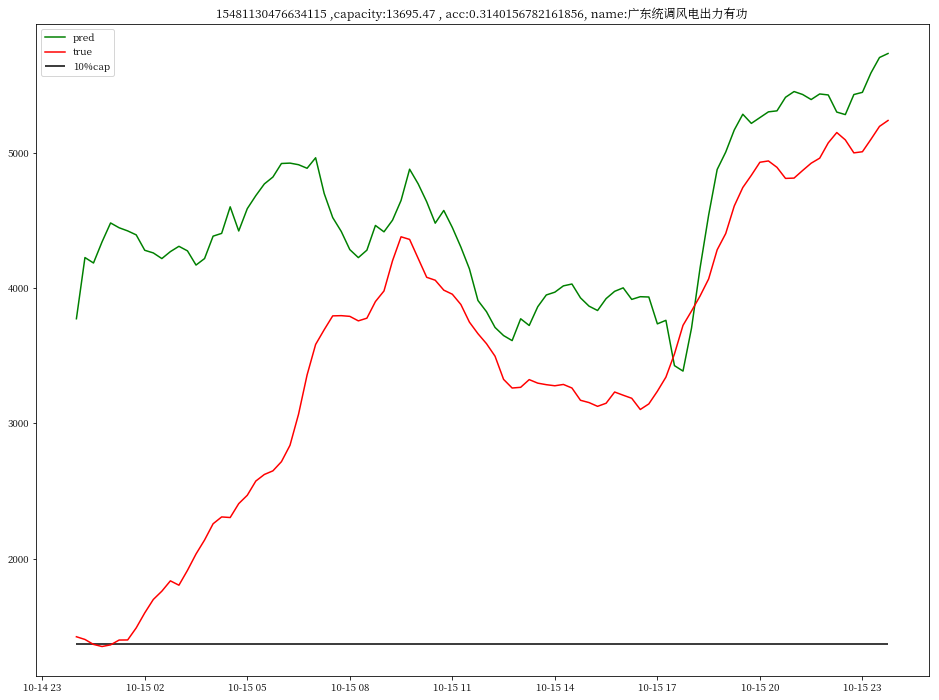

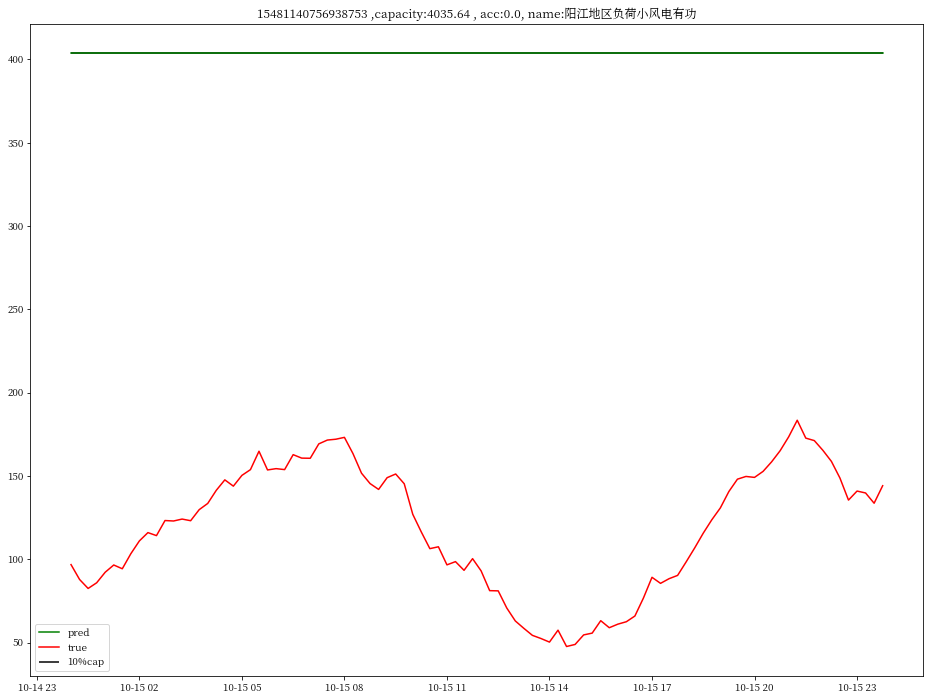

In [182]:
for date in pd.date_range('2023-10-15', '2023-10-15', freq='D'):
    df_pred1 = pd.read_pickle('results_v1/{}/df_pred_norm.p'.format(date.date()))
    df_pred2 = pd.read_pickle('results_v1/{}/df_pred_ct.p'.format(date.date()))
    df_pred = df_pred1.copy()
    df_pred['y_pred'] = (df_pred1['y_pred'] + df_pred2['y_pred'])/2
#     df_pred['y_pred'] = (df_pred1['y_pred'] + 2*df_pred2['y_pred'])/3
    dis_bad_oid(df_pred, acc_file='analyzise/acc_norm.csv', display=True)

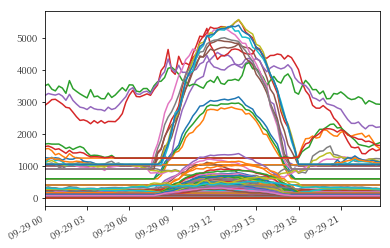

In [27]:
for oid, val in df_pred1.groupby('oid'):
    val['y_pred'].plot()
    df_pred2.loc[df_pred2['oid']==oid, 'y_pred'].plot()
    df_pred.loc[df_pred['oid']==oid, 'y_pred'].plot()

In [ ]:
df_pred2

In [ ]:
df_radi_align = pd.read_pickle('data/center_jiutian/2023-08-02-radi.p')
df_radi_align

In [13]:
df_radi_align = pd.read_pickle('test_his/center_jiutian/2023-09-01/df_radi_align.p')

In [ ]:
df_radi_align

In [ ]:
glob.glob('test_his/norm_lightGBM/2023-09-01/df_pred_*.p')
# df_t = pd.read_pickle(glob.glob('test_his/norm_lightGBM/2023-09-01/df_pred_*.p')[-1])
print(glob.glob('test_his/norm_lightGBM/2023-09-01/df_pred_*.p')[-1])

In [ ]:
import glob
acc_rate_ret_ls = []
for date in pd.date_range('2023-10-04', '2023-10-08', freq='D'):
    for file in glob.glob('test_his/center_jiutian_del/{}/df_pred.p'.format(date.date())):
        df_pred = pd.read_pickle(file)
#         print(file[-1])
        acc_rate_ret = dis_bad_oid(df_pred, acc_file='analyzise/acc_ct_del.csv')
        print(acc_rate_ret)
        acc_rate_ret_ls.append(acc_rate_ret)

In [28]:
import glob
acc_rate_ret_ls = []
for date in pd.date_range('2023-10-04', '2023-10-08', freq='D'):
    for file in glob.glob('test_his/norm_del/{}/df_pred_2023-10-09 17*.p'.format(date.date())):
        df_pred = pd.read_pickle(file)
#         print(file[-1])
        acc_rate_ret = dis_bad_oid(df_pred, acc_file='analyzise/acc_ct_del.csv')
        print(acc_rate_ret)
        acc_rate_ret_ls.append(acc_rate_ret)


2023-10-05 的准确率为
15481130821025794 0.8145412114715832
15481130821156866 0.5720322244585071
15481140766441473 0.7081991936682637
15481140766375937 0
15481140757135361 0
15481140757004289 0.6453236512179179
15481140757200897 0
15481140757069825 0.7088798942215058
15481140766179329 0.6805925036531633
15481140766113793 0.36935064219924474
15481137326915585 0.7591670440032727
15481140757266433 0.4350411884983493
15481130500882435 0.8808345513453336
15481130476634115 0.6230489195568707
15481125255184390 0.7904611670279016
15481129194225670 0.5240382781222679
15481140757790721 0.6981332685307616
15481140757725185 0.36427305174312485
15481130901110786 0.8233590488943725
15481131802034178 0
15481140766572545 0.6948853888604133
15481140766507009 0
15481140756873217 0.7625107799564871
15481140830863361 0
15481128891252742 0
15481128900034564 0.5984444875927484
15481140766310401 0.7591262035325478
15481140766244865 0.12327947751940305
15481140756807681 0.8608737946337721
15481140756938753 0
2023-1

In [ ]:
import glob
acc_rate_ret_ls = []
for date in pd.date_range('2023-09-19', '2023-09-26', freq='D'):
    for file1, file2 in zip(glob.glob(('results_v1/{}/df_pred.p'.format(date.date()))), glob.glob(('test_his/center_jiutian/{}/df_pred.p'.format(date.date())))):
        print(file1, file2)
        df_pred1 = pd.read_pickle(file1)
        df_pred2 = pd.read_pickle(file2)
        df_pred = df_pred1.copy()
        df_pred['y_pred'] = (df_pred1['y_pred'] + df_pred2['y_pred'])/2
        acc_rate_ret = dis_bad_oid(df_pred, acc_file='analyzise/acc_NORM_ct_fusion.csv')
        print(acc_rate_ret)
        acc_rate_ret_ls.append(acc_rate_ret)

In [112]:
df_radi = pd.read_pickle('data/center_jiutian/2023-10-07-radi.p')
df_cp = pd.read_pickle('data/center_jiutian/center_points.p')

In [131]:
df_oid = pd.read_pickle('data/oid/newest.p')

In [ ]:
df_oid

In [ ]:
df_rd_ct.mean()

In [113]:
df_cp.loc[df_cp.oid == '15481130821025794'].values

array([[99.60050663, 23.68235734, 1128.0, '15481130821025794', 163],
       [100.16904907, 25.81133219, 2638.92, '15481130821025794', 163],
       [100.84604967, 25.20002341, 3479.75, '15481130821025794', 163],
       [103.25839722, 24.24956313, 1857.5, '15481130821025794', 163],
       [102.79059829, 26.16275098, 1829.35, '15481130821025794', 163]],
      dtype=object)

In [114]:
df_cp.loc[df_cp.oid == '15481130821025794', 'jd'].values

array([ 99.60050663, 100.16904907, 100.84604967, 103.25839722,
       102.79059829])

In [118]:
(df_radi.jd == 99.60050663).sum()

96

In [138]:
df_radi_ls = []
for date in pd.date_range('2023-09-01', '2023-10-07', freq='D'):
    df_radi_ls.append(pd.read_pickle('data/center_jiutian/{}-radi.p'.format(date.date())))
df_radi = pd.concat(df_radi_ls)
df_radi_ls_ = []
for jd, wd in zip(df_cp.loc[df_cp.oid == '15481140757135361', 'jd'].values, df_cp.loc[df_cp.oid == '15481140757135361', 'wd'].values):
    df_tmp = df_radi.loc[(df_radi.jd==jd) & (df_radi.wd==wd)]
    df_radi_ls_.append(df_tmp)

In [ ]:
for df_ in df_radi_ls_:
    print(df_.jd.values[0], df_.wd.values[0])
    plt.figure(figsize=(24, 8))
    plt.plot(df_.total_radiation)

In [ ]:
df_pred = pd.read_pickle('results_v1/2023-09-24/df_pred.p')
dis_bad_oid(df_pred, acc_file='analyzise/acc.csv')

In [194]:
radi_oid_list = ['15481140756807681','15481140756873217','15481140766179329','15481140766310401','15481140757790721',
                  '15481140757135361','15481140757200897','15481140766441473','15481140766572545','15481137326915585',
                  '15481130500882435','15481125255184390','15481128891252742','15481130821025794','15481130901110786']
df_pred_ls = []
df_pred_hand_ls = []


for date in pd.date_range('2023-10-09', '2023-10-15', freq="D"):
    dir_data_ct = 'results_v1/{}/df_pred_ct.p'.format(date.date())
    dir_data_norm = 'results_v1/{}/df_pred_norm.p'.format(date.date())
    dir_data_hand = 'results_v1/{}/df_pred_hand.p'.format(date.date())
    df_pred_ct = pd.read_pickle(dir_data_ct)
    df_pred_norm = pd.read_pickle(dir_data_norm)
    df_pred_hand = pd.read_pickle(dir_data_hand)
    df_pred = df_pred_ct.copy()
    df_pred.y_pred = (df_pred_ct.y_pred + df_pred_norm.y_pred) / 2
    df_pred_ls.append(df_pred)
    df_pred_hand_ls.append(df_pred_hand)

df_power = pd.read_pickle('results_v1/2023-10-17/df_power.p')
df = pd.concat(df_pred_ls)
df_hand_all = pd.concat(df_pred_hand_ls)
df_power = df_power.loc[df.index.unique()]
df.index = df.index.tz_localize(None)
df_power.index = df_power.index.tz_localize(None)
df_hand_all.index = df_hand_all.index.tz_localize(None)
for oid, df_oid in df.groupby('oid'):
    if oid not in radi_oid_list:
        continue
    df_station = pd.read_pickle('data/oid/newest.p')
    plt.figure(figsize=(24, 8))
    oid_name = df_station.loc[df_station['oid']==oid, 'data_name'].values[0]
    df_power_tmp = df_power.loc[df_power.oid == oid]
    df_hand_tmp = df_hand_all.loc[df_hand_all.oid == oid]
#     print(df_power_tmp, df_oid)
    date_rate_ls = []
    date_rate_hand_ls = []
    for date in pd.date_range('2023-10-09', '2023-10-15', freq="D"):
        df_oid_date = df_oid.loc[str(date.date())]
        df_hand_date = df_hand_tmp.loc[str(date.date())]
        df_power_date = df_power_tmp.loc[str(date.date())]
        acc_rate,acc_list, oid_list = calc_acc_oid(df_oid_date, df_power_date, df_station)
        acc_rate_h,acc_list_h, oid_list_h = calc_acc_oid(df_hand_date, df_power_date, df_station)
        if not np.isnan(acc_rate):
            date_rate_ls.append(acc_rate)
        if not np.isnan(acc_rate_h):
            date_rate_hand_ls.append(acc_rate_h)
    acc_rate = np.mean(date_rate_ls)
    acc_rate_h = np.mean(date_rate_hand_ls)
    print(oid, oid_name, '\t', acc_rate - acc_rate_h)
    cap = df_station.loc[df_station['oid']==oid, 'capacity'].values[0]
    plt.plot(df_oid.y_pred, color='g',label='pred')
    plt.hlines(cap * 0.1, df_oid.index[0],  df_oid.index[-1], label='10%cap', color='black')
    plt.plot(df_power.loc[df_power.oid == oid, 'power'], color='r',label='true')
    plt.plot(df_hand_all.loc[df_hand_all.oid == oid, 'y_pred'], color='b',label='hand')
    plt.title('oid:{}\tname:{}\tacc:{}'.format(oid, oid_name,acc_rate))
    plt.legend()

AttributeError: module 'numpy' has no attribute 'isna'

<Figure size 1728x576 with 0 Axes>

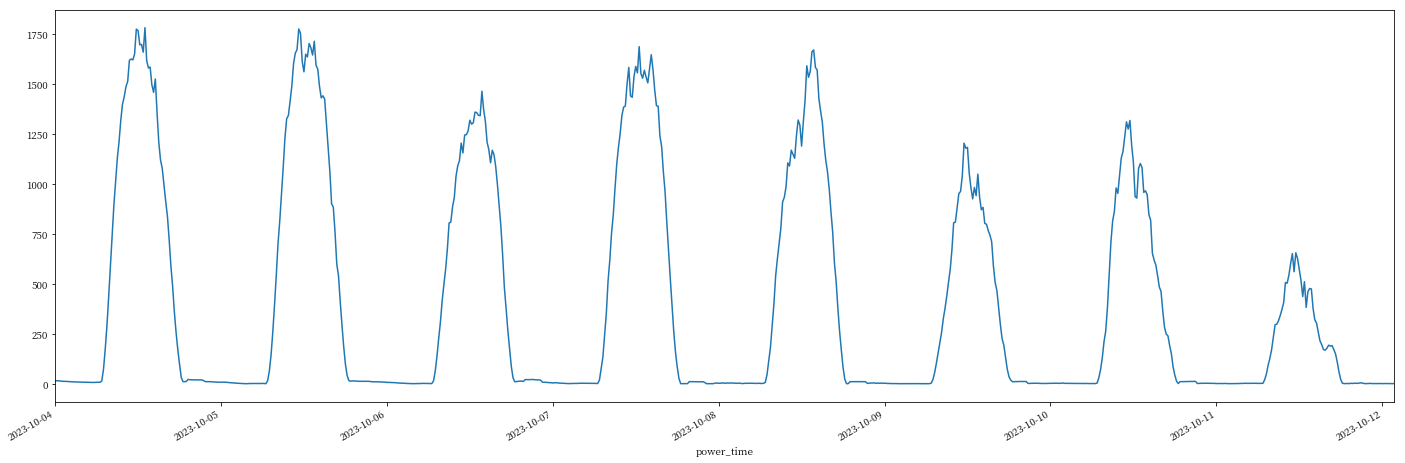

In [83]:
df_power = pd.read_pickle('results_v1/2023-10-13/df_power.p')
df_power = df_power.loc[df_power['oid'] == '15481130901110786', :]
df_power['power'] = df_power['power'].astype(float)
df_power.loc['2023-10-04':, 'power'].plot(figsize=(24, 8))

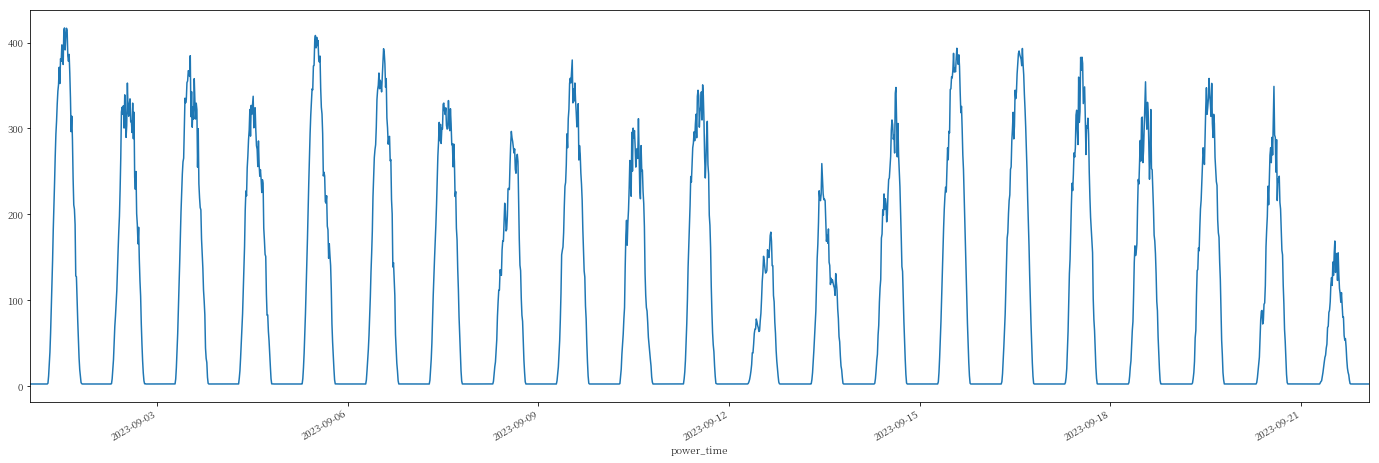

In [25]:
df_pred_lps = df_pred.loc[df_pred['oid'] == '15481140757135361', :]
df_pred_lps['power'] = df_pred_lps['power'].astype(float)
df_pred_lps.loc['2023-09-01':, 'power'].plot(figsize=(24, 8))

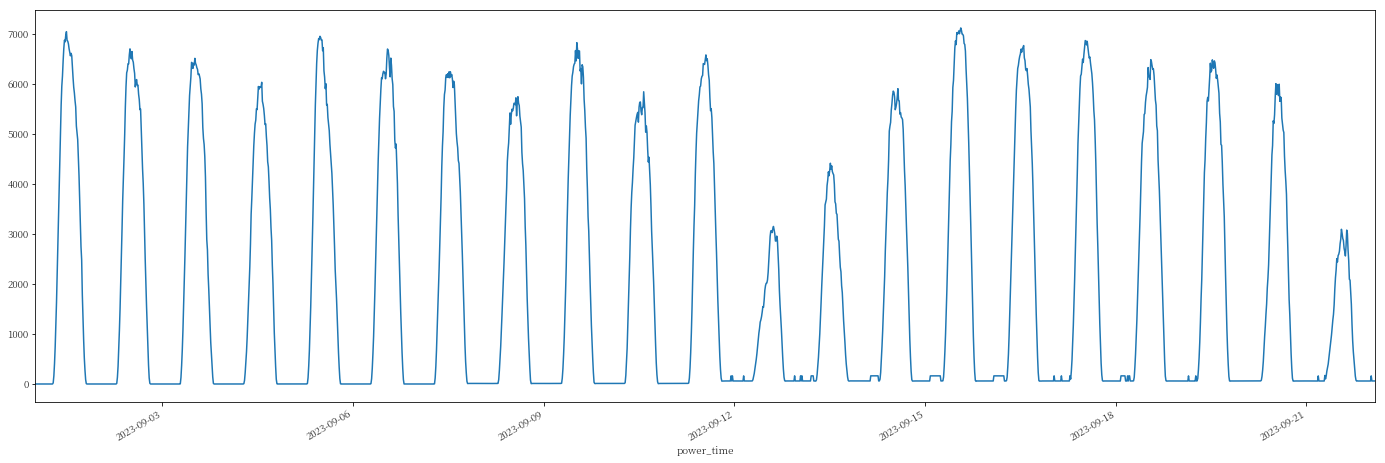

In [23]:
df_pred_lps = df_pred.loc[df_pred['oid'] == '15481128891252742', :]
df_pred_lps['power'] = df_pred_lps['power'].astype(float)
df_pred_lps.loc['2023-09-01':, 'power'].plot(figsize=(24, 8))

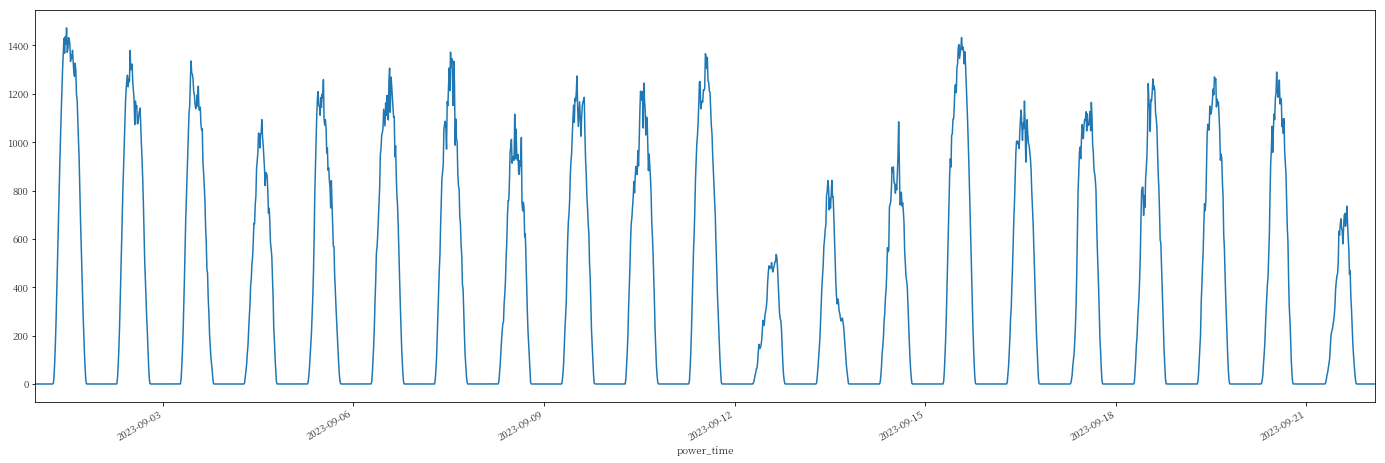

In [24]:
df_pred_lps = df_pred.loc[df_pred['oid'] == '15481140757200897', :]
df_pred_lps['power'] = df_pred_lps['power'].astype(float)
df_pred_lps.loc['2023-09-01':, 'power'].plot(figsize=(24, 8))

### 测试保底的代码

In [28]:
def test_baseline(date_):
    df_all = pd.read_pickle('results_v1/2023-09-19/df_power.p')
    prev_date = str((datetime.datetime.strptime(date_, '%Y-%m-%d') - datetime.timedelta(days=2)).date())
    df_prev = df_all.loc[prev_date:prev_date, ['oid', 'power']]
    df_post = df_all.loc[date_:date_, ['oid', 'power']]
    
    df_prev = df_prev.rename({'power' : 'y_pred'}, axis=1)
    df_prev.index += datetime.timedelta(days=2)
    
    acc_rate_ret = dis_bad_oid(df_prev, acc_file='analyzise/acc_baseline.csv')
    return acc_rate_ret

2023-09-16 的准确率为
15481125255184390 0.5374379246069034
15481128891252742 0.8565287216555695
15481128900034564 0.6840704556985358
15481129194225670 -2.622800180029203
15481130476634115 0.4814314362546388
15481130500882435 0.7383053643754363
15481130821025794 0.9174536522671322
15481130821156866 0.9418869566450803
15481130901110786 0.29344890898816534
15481131802034178 0.2671316384549862
15481137326915585 0.868759437199881
15481140756807681 0.6561584401206327
15481140756873217 0.20917844610883862
15481140756938753 0.4312346520874315
15481140757004289 0.3966243375683721
15481140757069825 0.32852963981779737
15481140757135361 0.7717831018305228
15481140757200897 0.7484191241834126
15481140757725185 0.2050012698966317
15481140757790721 0.8618672450032931
15481140766113793 -2.858573974364119
15481140766179329 0.5435232724120855
15481140766244865 -2.2865099609574027
15481140766310401 0.757633928225096
15481140766375937 0.19924387276281397
15481140766441473 -0.335355938414059
15481140766507009 

0.44885102506983293

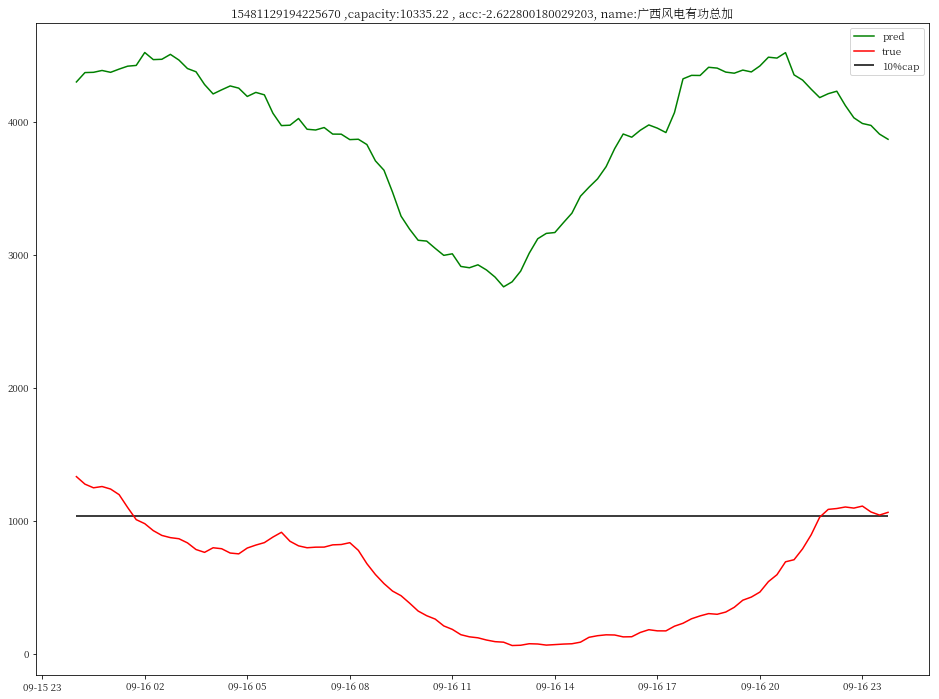

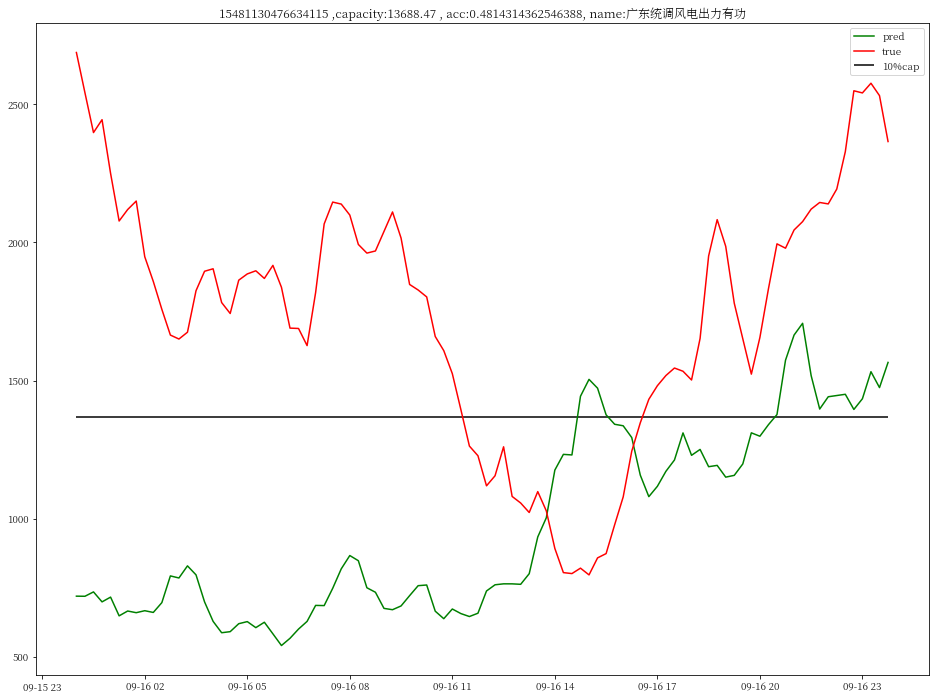

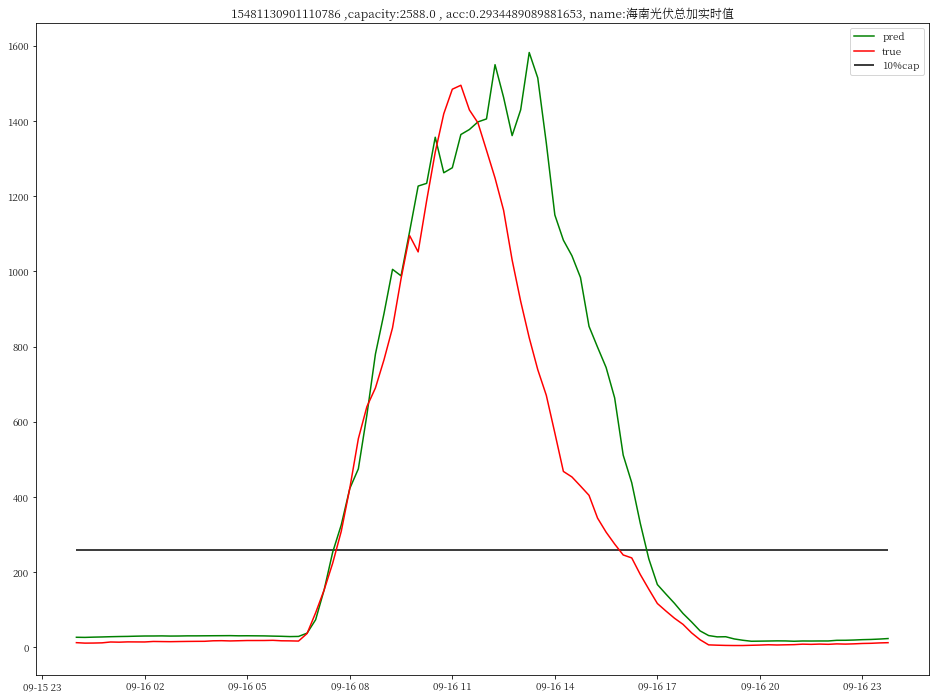

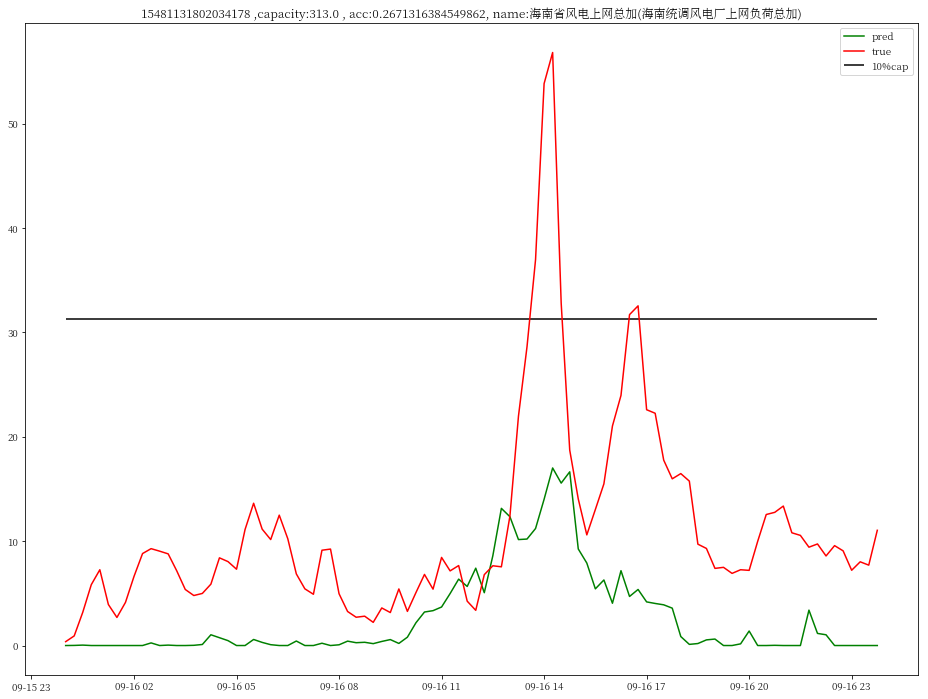

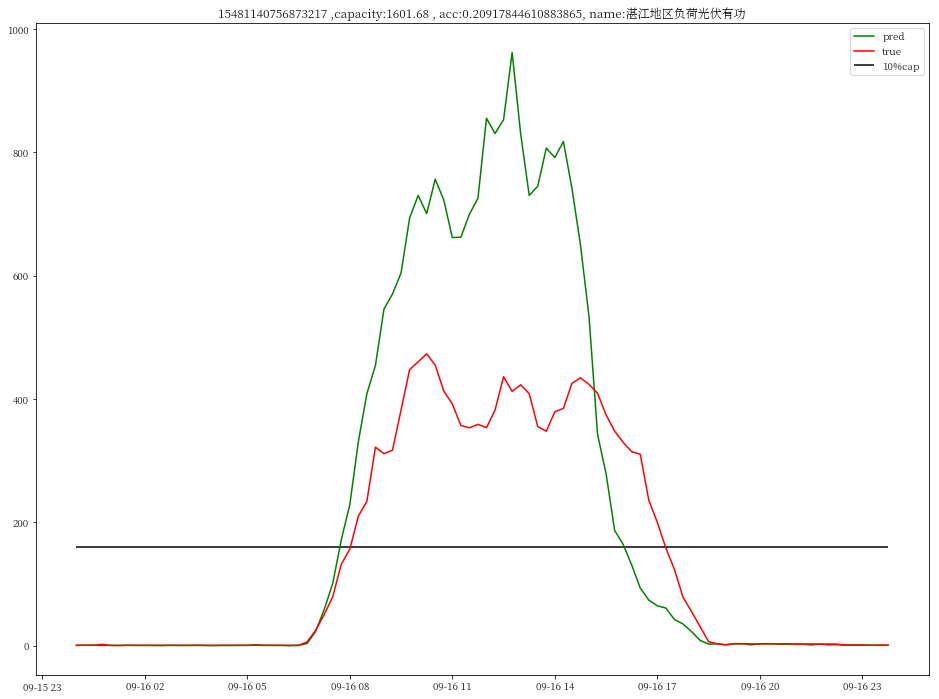

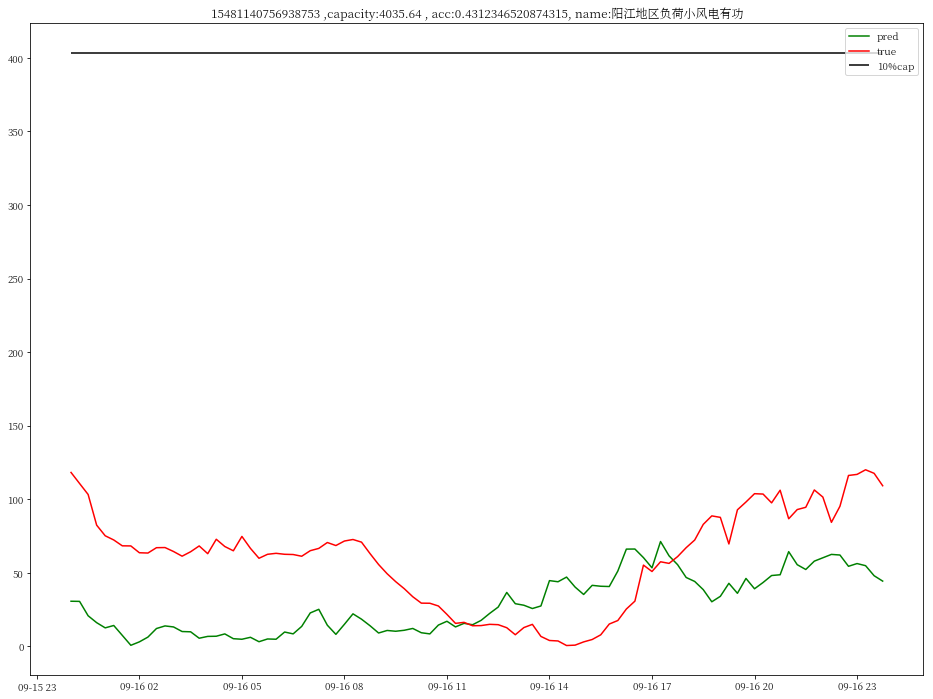

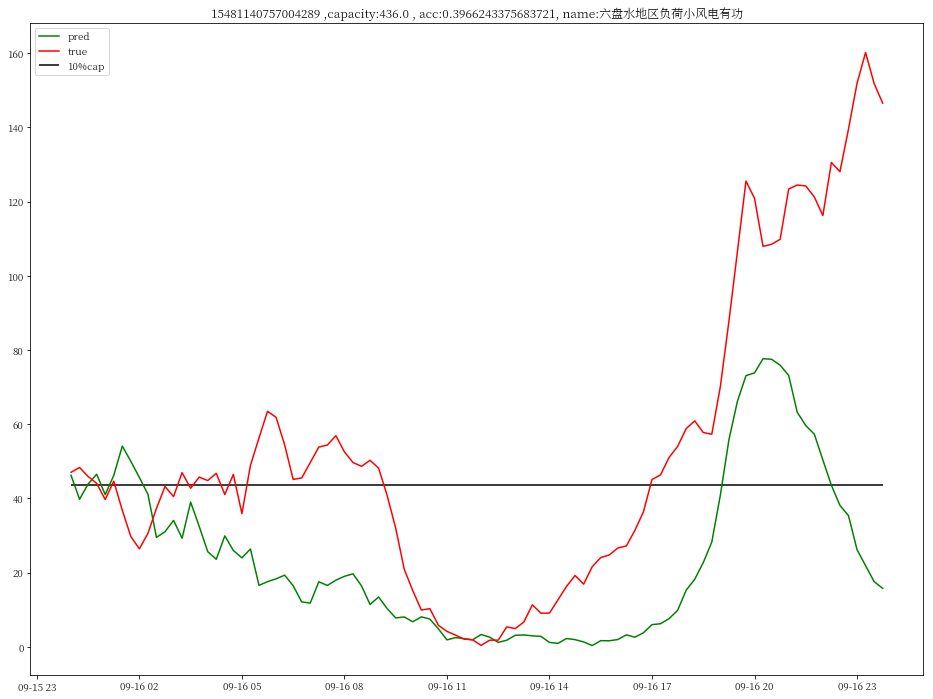

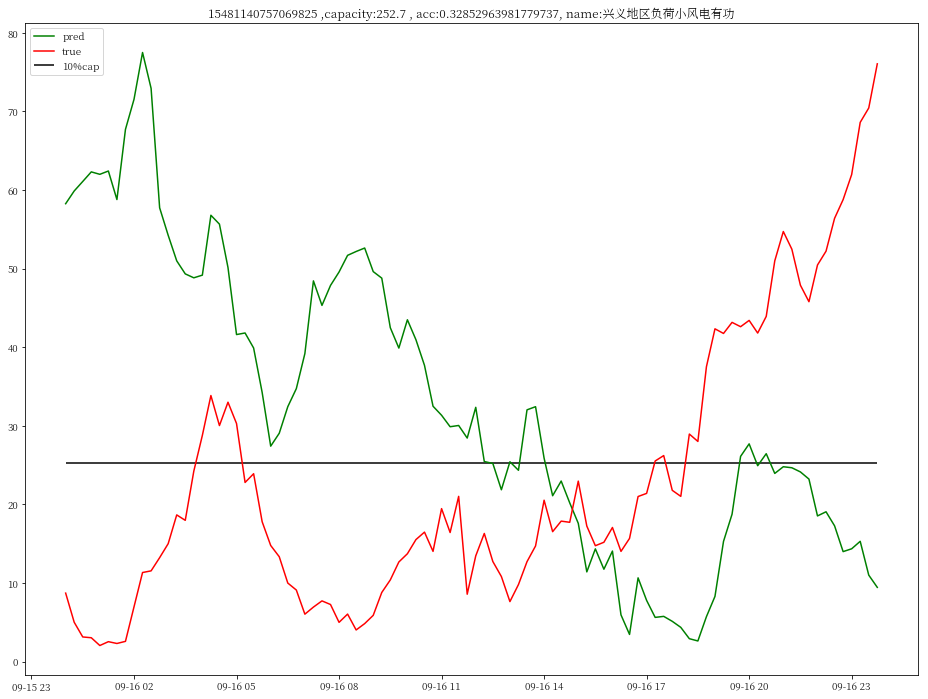

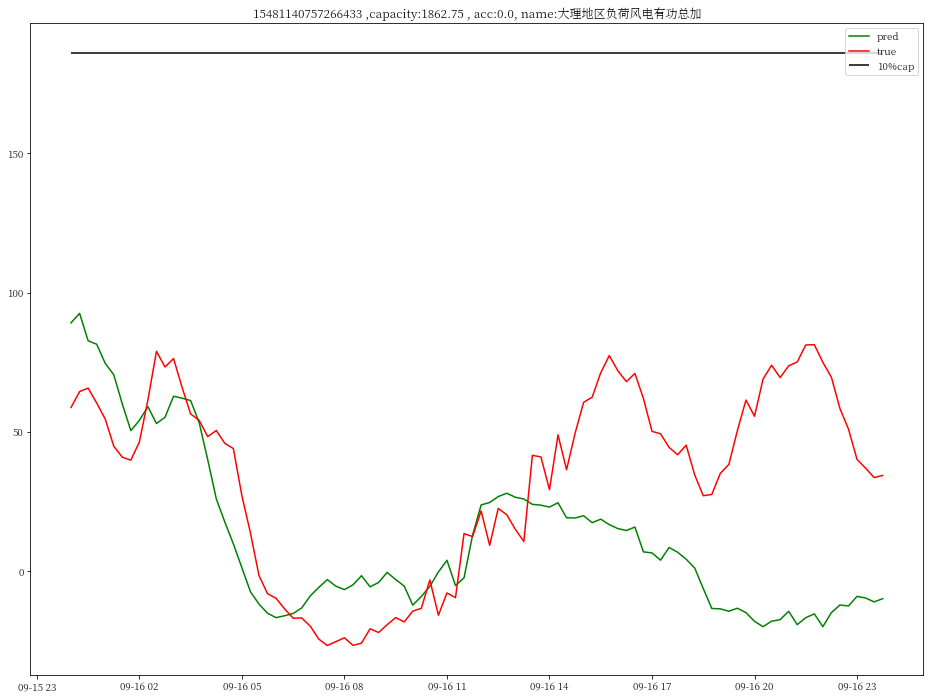

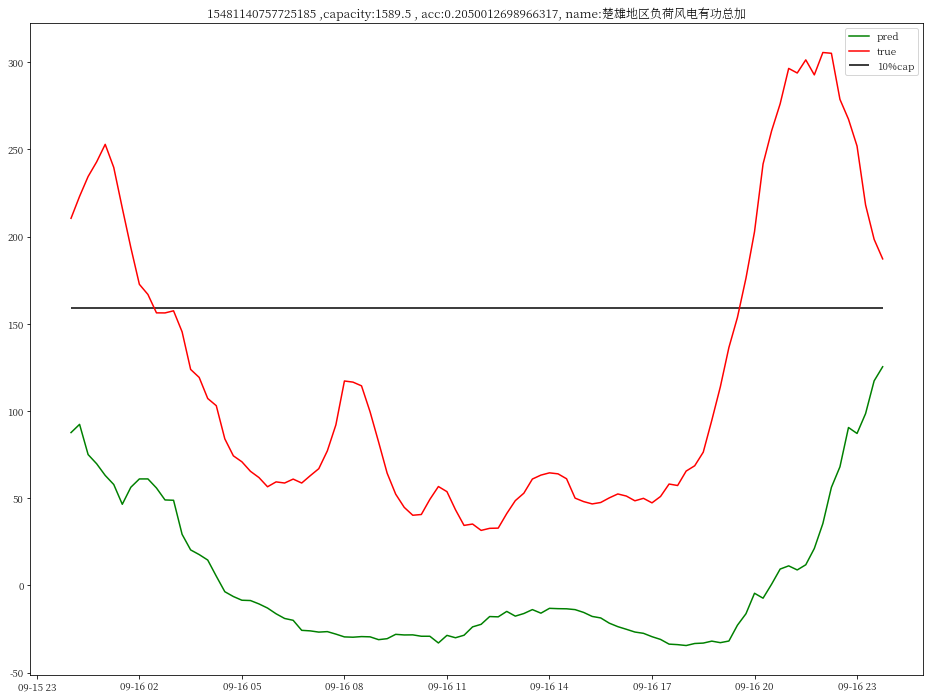

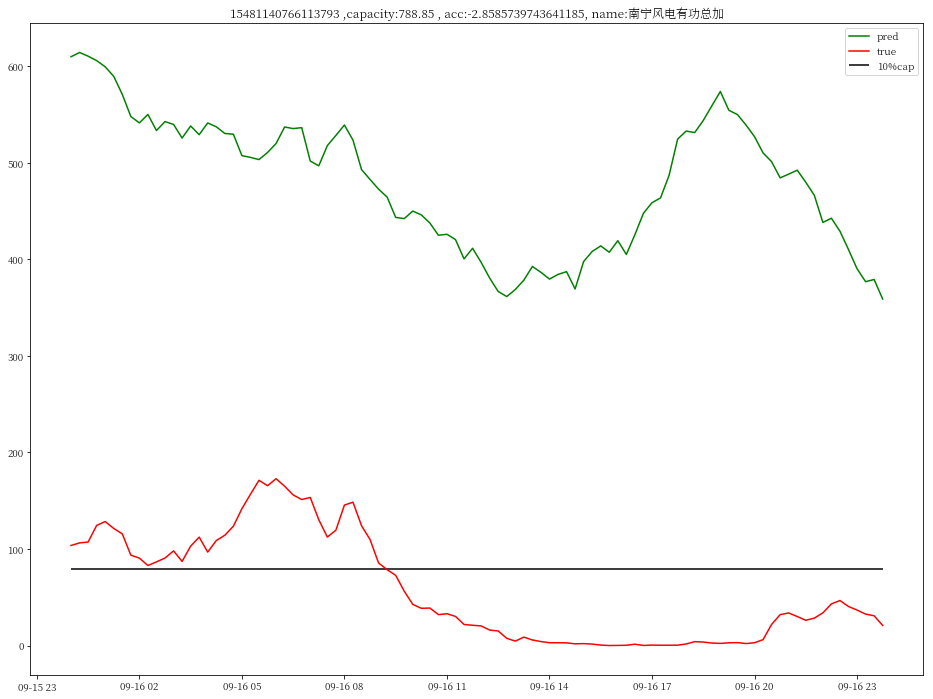

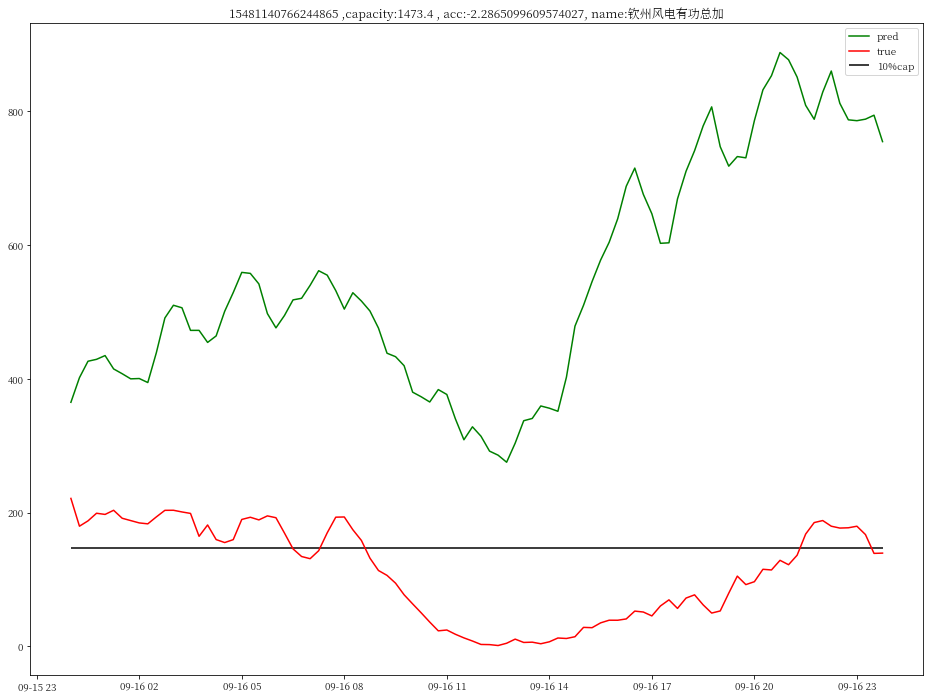

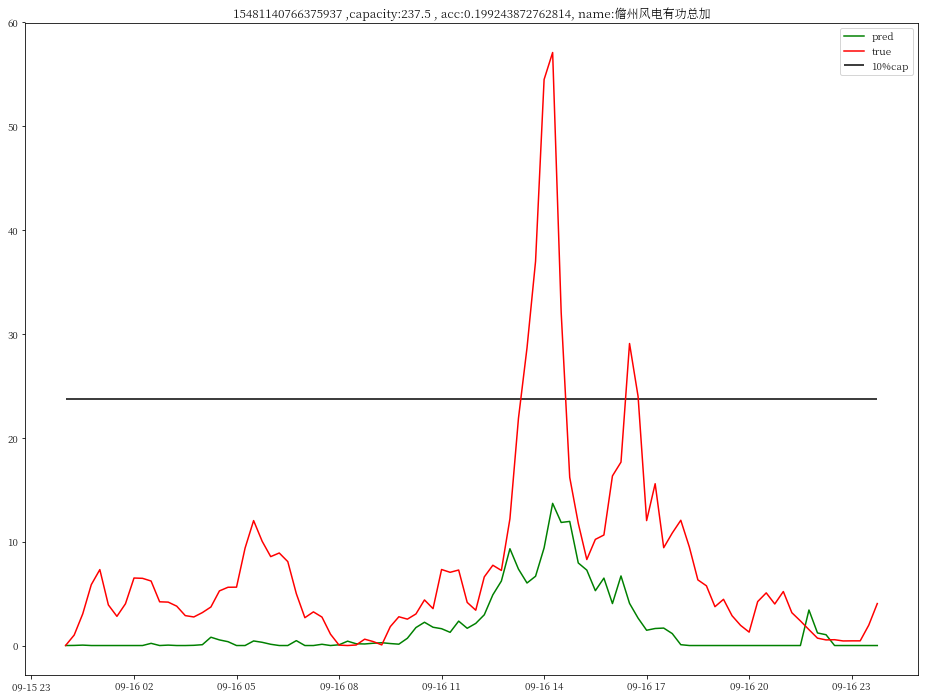

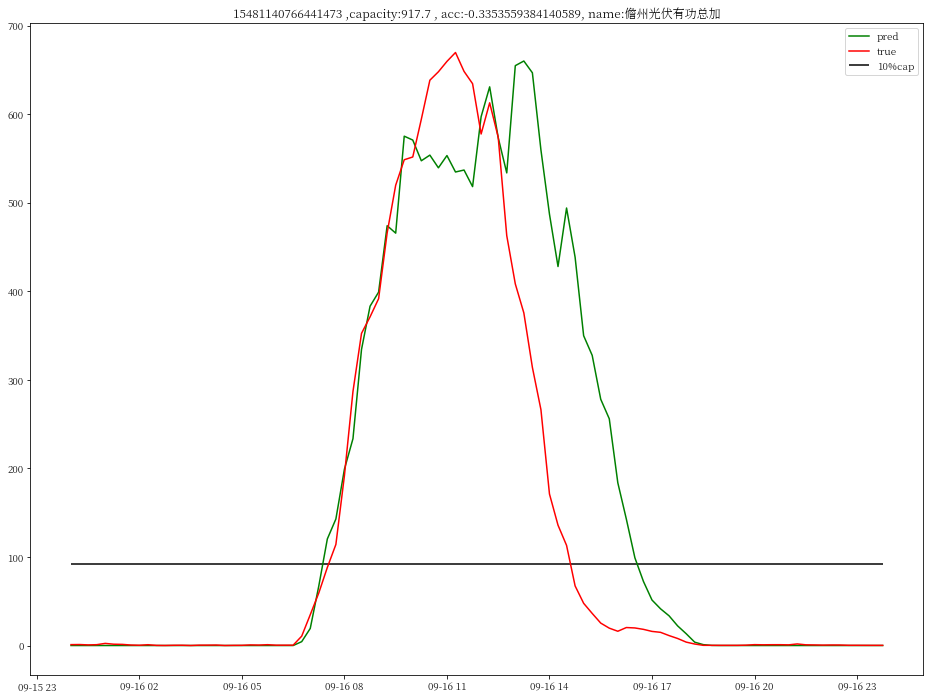

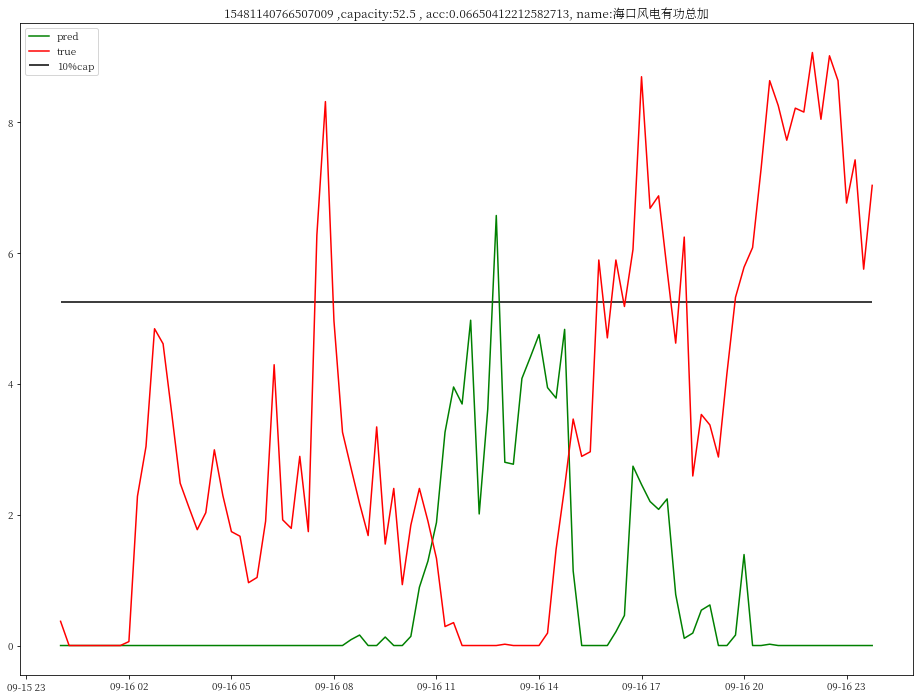

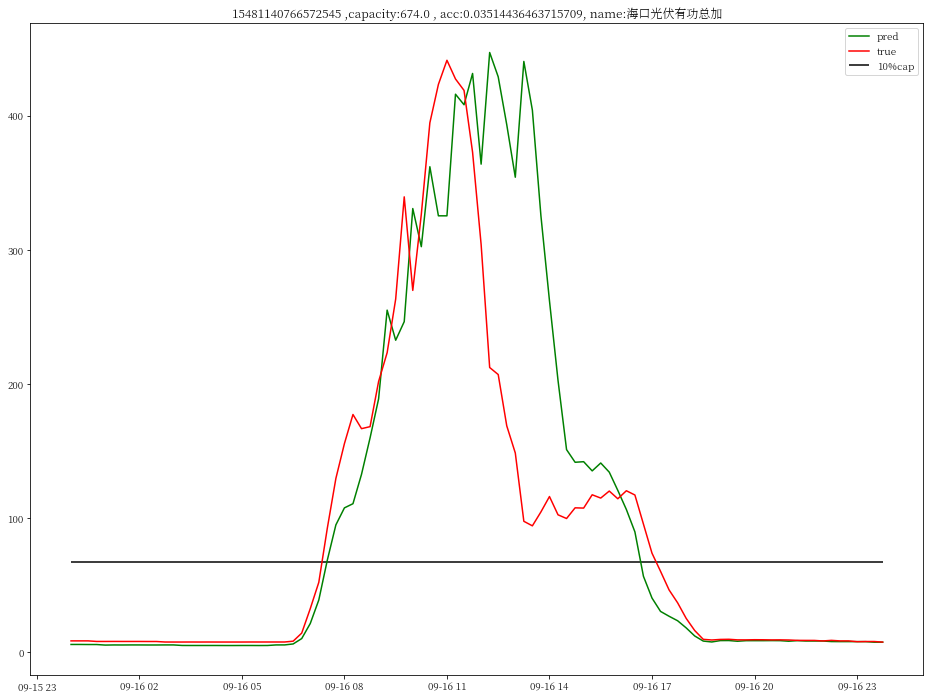

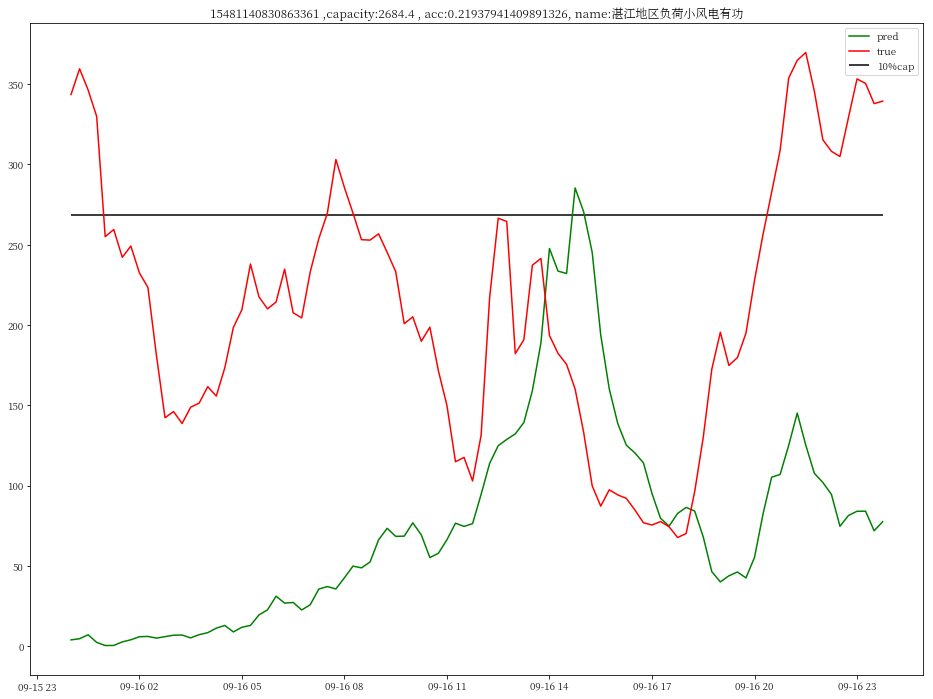

In [31]:
test_baseline('2023-09-16')

In [ ]:
import catboost as cb
model = cb.CatBoostRegressor()
model.load_model('test_his/center_jiutian_del/2023-10-04/15481140757135361')
feau_impo = model.get_feature_importance()
feau_name = model.feature_names_
df = pd.DataFrame({'name':feau_name, 'impo':feau_impo})
df.sort_values('impo', ascending=False)

In [53]:
df_jiutian2qxj = pd.read_pickle('data/jiutian2qxj_regr/2023-09-19/wind.p')

In [91]:
df_jiutian2qxj = pd.read_pickle('data/jiutian2qxj_regr/2023-09-01/wind.p')

In [95]:
df_power = pd.read_pickle('results_v1/{}/df_power.p'.format('2023-09-01'))

In [31]:
df_qxj = pd.read_pickle('data/qxj_weather/2023-09-18.p')

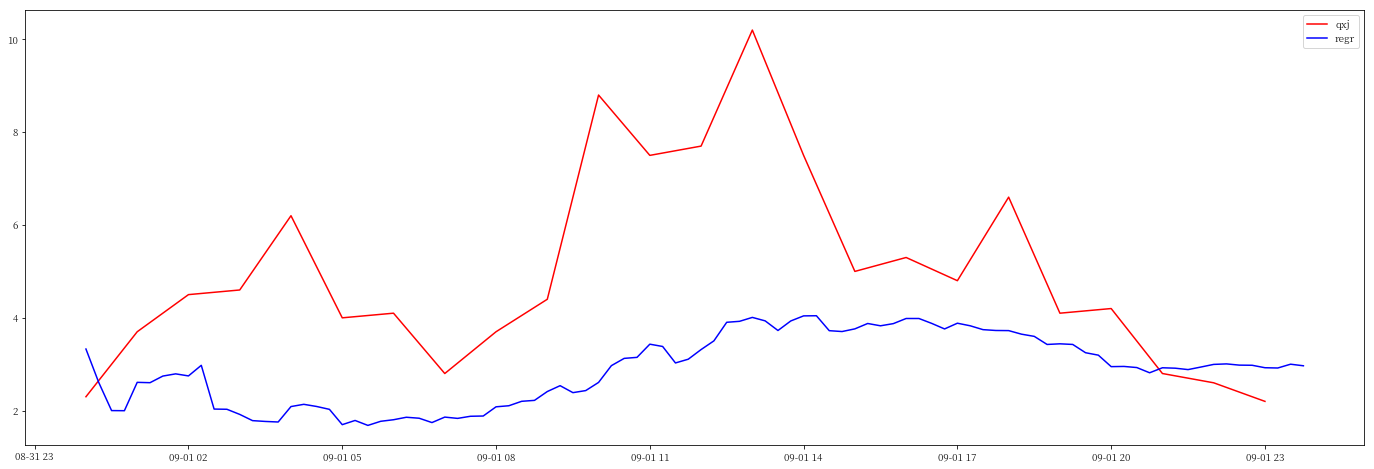

In [90]:
date = '2023-09-01'
df_jiutian2qxj = pd.read_pickle('data/jiutian2qxj_regr/{}/wind.p'.format(date))
df_qxj = pd.read_pickle('data/qxj_weather/{}.p'.format(date))
loc = 390
plt.figure(figsize=(24,8))
show_qxj = df_qxj[['jd','wd', 'zlsc', 'pjfs2fz']].sort_values(['jd', 'wd', 'zlsc']).iloc[(loc-1)*96:loc*96].replace(9999, np.nan).dropna()
show_qxj['zlsc'].apply(pd.to_datetime)
show_qxj['pjfs2fz'].apply(pd.to_numeric)
show_qxj.set_index('zlsc')
show_jiutian2qxj = df_jiutian2qxj.loc[date:date, 'pjfs2fz']
plt.plot(show_qxj['zlsc'], show_qxj['pjfs2fz'], color='r', label='qxj')
plt.plot(show_jiutian2qxj[(loc-1)*96:loc*96], color='b', label='regr')
plt.legend()

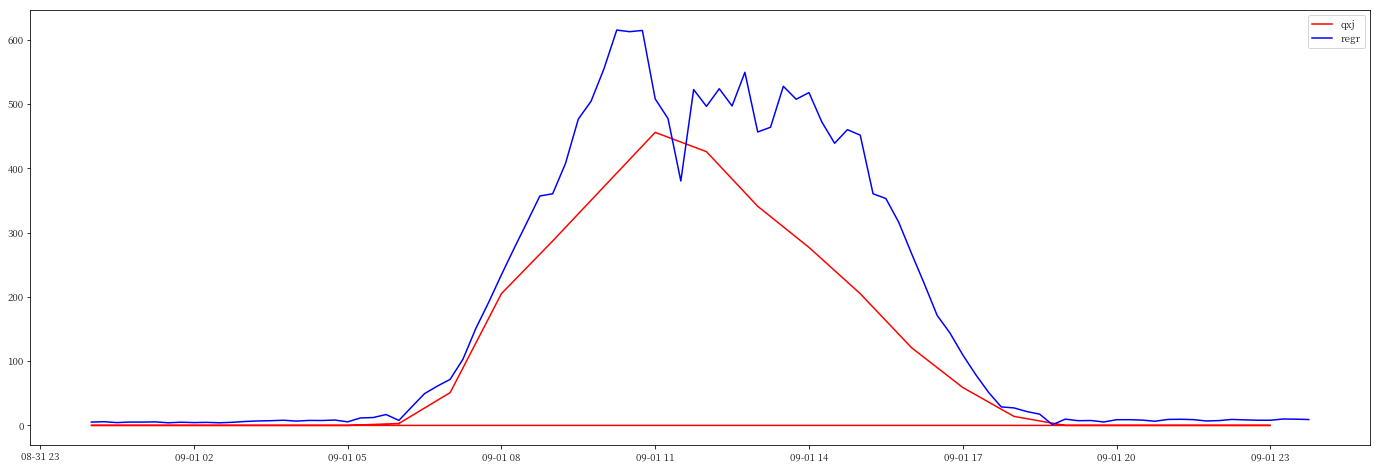

In [77]:
date = '2023-09-01'
df_jiutian2qxj = pd.read_pickle('data/jiutian2qxj_regr/{}/radi.p'.format(date))
df_qxj = pd.read_pickle('data/qxj_radiation/{}.p'.format(date))
loc = 15
plt.figure(figsize=(24,8))
show_qxj = df_qxj[['jd','wd', 'zlsc', 'zfzd']].sort_values(['jd', 'wd', 'zlsc']).iloc[(loc-1)*24:loc*24].replace(9999, np.nan).dropna()
show_qxj['zlsc'].apply(pd.to_datetime)
show_qxj['zfzd'].apply(pd.to_numeric)
show_qxj.set_index('zlsc')
show_jiutian2qxj = df_jiutian2qxj.loc[date:date, 'zfzd']
plt.plot(show_qxj['zlsc'], show_qxj['zfzd'], color='r', label='qxj')
plt.plot(show_jiutian2qxj[(loc-1)*96:loc*96],color='b', label='regr')
plt.legend()

In [64]:
show_jiutian2qxj = df_jiutian2qxj.loc[date:date, 'zfzd']b

In [ ]:
show_jiutian2qxj[:96]

In [172]:
df_pred_ct = pd.read_pickle('results_v1/2023-10-17/df_pred_ct.p')
df_pred_norm = pd.read_pickle('results_v1/2023-10-17/df_pred_norm.p')
df_pred = df_pred_ct.copy()
df_pred.y_pred = (df_pred_norm.y_pred + df_pred_ct.y_pred) / 2


In [36]:
df_pred.head()

,oid,type,y_pred
2023-10-11 00:00:00+08:00,15481125255184390,5,609.79
2023-10-11 00:15:00+08:00,15481125255184390,5,609.79
2023-10-11 00:30:00+08:00,15481125255184390,5,609.79
2023-10-11 00:45:00+08:00,15481125255184390,5,609.79
2023-10-11 01:00:00+08:00,15481125255184390,5,609.79


In [173]:
radi_oid_list = ['15481140756807681','15481140756873217','15481140766179329','15481140766310401','15481140757790721',
                  '15481140757135361','15481140757200897','15481140766441473','15481140766572545','15481137326915585',
                  '15481130500882435','15481125255184390','15481128891252742','15481130821025794','15481130901110786']
radi_name_ls = ['阳江', '湛江', '南宁', '钦州', '楚雄', '六盘水', '兴义', '儋州', '海口', '大理', '广东', '广西', '贵州', '云南', '海南']
radi_max_ls = []
for idx, oid in enumerate(radi_oid_list):
    max_ = df_pred_ct.loc[df_pred_ct['oid'] == oid, 'y_pred'].max()
    radi_max_ls.append(max_)
    print(radi_name_ls[idx], '光伏预测最大值为\t : ',max_, '\toid : ' +oid,)

阳江 光伏预测最大值为	 :  594.5189396827699 	oid : 15481140756807681
湛江 光伏预测最大值为	 :  811.2252928482212 	oid : 15481140756873217
南宁 光伏预测最大值为	 :  563.513349705445 	oid : 15481140766179329
钦州 光伏预测最大值为	 :  435.5588164325216 	oid : 15481140766310401
楚雄 光伏预测最大值为	 :  859.0471597812706 	oid : 15481140757790721
六盘水 光伏预测最大值为	 :  305.05581898307094 	oid : 15481140757135361
兴义 光伏预测最大值为	 :  1225.9020356439325 	oid : 15481140757200897
儋州 光伏预测最大值为	 :  416.5154725574323 	oid : 15481140766441473
海口 光伏预测最大值为	 :  225.21874327977122 	oid : 15481140766572545
大理 光伏预测最大值为	 :  731.0170904767375 	oid : 15481137326915585
广东 光伏预测最大值为	 :  5313.466803117247 	oid : 15481130500882435
广西 光伏预测最大值为	 :  3640.5295337430666 	oid : 15481125255184390
贵州 光伏预测最大值为	 :  6179.5822447049895 	oid : 15481128891252742
云南 光伏预测最大值为	 :  5903.625763538638 	oid : 15481130821025794
海南 光伏预测最大值为	 :  934.6269517940517 	oid : 15481130901110786


In [174]:
radi_oid_list = ['15481140756807681','15481140756873217','15481140766179329','15481140766310401','15481140757790721',
                  '15481140757135361','15481140757200897','15481140766441473','15481140766572545','15481137326915585',
                  '15481130500882435','15481125255184390','15481128891252742','15481130821025794','15481130901110786']
radi_name_ls = ['阳江', '湛江', '南宁', '钦州', '楚雄', '六盘水', '兴义', '儋州', '海口', '大理', '广东', '广西', '贵州', '云南', '海南']
radi_max_ls = []
for idx, oid in enumerate(radi_oid_list):
    max_ = df_pred_norm.loc[df_pred_norm['oid'] == oid, 'y_pred'].max()
    radi_max_ls.append(max_)
    print(radi_name_ls[idx], '光伏预测最大值为\t : ',max_, '\toid : ' +oid,)

阳江 光伏预测最大值为	 :  491.3774121703772 	oid : 15481140756807681
湛江 光伏预测最大值为	 :  769.9896080441697 	oid : 15481140756873217
南宁 光伏预测最大值为	 :  428.5290237698909 	oid : 15481140766179329
钦州 光伏预测最大值为	 :  392.62494325734906 	oid : 15481140766310401
楚雄 光伏预测最大值为	 :  652.6788543723803 	oid : 15481140757790721
六盘水 光伏预测最大值为	 :  248.98869920036137 	oid : 15481140757135361
兴义 光伏预测最大值为	 :  945.364575208006 	oid : 15481140757200897
儋州 光伏预测最大值为	 :  434.3526597784816 	oid : 15481140766441473
海口 光伏预测最大值为	 :  311.37826184399336 	oid : 15481140766572545
大理 光伏预测最大值为	 :  648.8063025283691 	oid : 15481137326915585
广东 光伏预测最大值为	 :  4290.361585579362 	oid : 15481130500882435
广西 光伏预测最大值为	 :  2805.9808471128 	oid : 15481125255184390
贵州 光伏预测最大值为	 :  4547.340064279534 	oid : 15481128891252742
云南 光伏预测最大值为	 :  4556.697346648805 	oid : 15481130821025794
海南 光伏预测最大值为	 :  1229.1094957705102 	oid : 15481130901110786


In [175]:
radi_oid_list = ['15481140756807681','15481140756873217','15481140766179329','15481140766310401','15481140757790721',
                  '15481140757135361','15481140757200897','15481140766441473','15481140766572545','15481137326915585',
                  '15481130500882435','15481125255184390','15481128891252742','15481130821025794','15481130901110786']
radi_name_ls = ['阳江', '湛江', '南宁', '钦州', '楚雄', '六盘水', '兴义', '儋州', '海口', '大理', '广东', '广西', '贵州', '云南', '海南']
radi_max_ls = []
for idx, oid in enumerate(radi_oid_list):
    max_ = df_pred.loc[df_pred['oid'] == oid, 'y_pred'].max()
    radi_max_ls.append(max_)
    print(radi_name_ls[idx], '光伏预测最大值为\t : ',max_, '\toid : ' +oid,)

阳江 光伏预测最大值为	 :  542.9481759265735 	oid : 15481140756807681
湛江 光伏预测最大值为	 :  790.6074504461955 	oid : 15481140756873217
南宁 光伏预测最大值为	 :  495.2473197789129 	oid : 15481140766179329
钦州 光伏预测最大值为	 :  404.38383309161907 	oid : 15481140766310401
楚雄 光伏预测最大值为	 :  743.7892732975765 	oid : 15481140757790721
六盘水 光伏预测最大值为	 :  272.3985782582023 	oid : 15481140757135361
兴义 光伏预测最大值为	 :  1058.0639563245913 	oid : 15481140757200897
儋州 光伏预测最大值为	 :  409.9026520126172 	oid : 15481140766441473
海口 光伏预测最大值为	 :  267.9418612829313 	oid : 15481140766572545
大理 光伏预测最大值为	 :  678.4821538255533 	oid : 15481137326915585
广东 光伏预测最大值为	 :  4767.10521690223 	oid : 15481130500882435
广西 光伏预测最大值为	 :  3220.6064383818875 	oid : 15481125255184390
贵州 光伏预测最大值为	 :  5322.781943220606 	oid : 15481128891252742
云南 光伏预测最大值为	 :  5138.986308412712 	oid : 15481130821025794
海南 光伏预测最大值为	 :  1055.2758136187347 	oid : 15481130901110786


In [180]:
nw_pred_max_dic = {
    "广东":4387.11,
    "阳江":538.08,
    "湛江":797.85,
    "广西":3533.93,
    "南宁":640.34,
    "钦州":517.22,
    "贵州":3115.15,
    "六盘水":208.61,
    "兴义":716.36,
    "海南":791.7,
    "儋州":262.63,
    "海口":219.97,
    "云南":5008.77,
    "楚雄":942.73,
    "大理":1054.22,
}




In [166]:
nw_pred_max_dic = {
    '阳江' : 480,
    '湛江' : 600,
    '南宁' : 440,
    '钦州' : 440,
    #'楚雄' : 870,
    '六盘水' : 200,
    '兴义' : 520,
    '儋州' : 236,
    '海口' : 262,
    #'大理' : 1074,
    '广东' : 4186,
    #'广西' : 2355,
    #'贵州' : 2600,
    '云南' : 4636,
    '海南' : 767,
}

In [181]:
df_pred_norm = pd.read_pickle('results_v1/2023-10-15/df_pred_norm.p')
df_pred_ct = pd.read_pickle('results_v1/2023-10-15/df_pred_ct.p')
df_pred = df_pred_norm.copy()
df_pred.y_pred = (df_pred_norm.y_pred + df_pred_ct.y_pred) / 2
df_pred = post_pro_hand_no_send(nw_pred_max_dic, df_pred)

In [63]:
df_pred.loc[df_pred.oid=='15481140757200897', 'y_pred'].max()

640.0

In [64]:
((df_pred_norm.loc[df_pred_norm.oid=='15481140757200897', 'y_pred'] + df_pred_ct.loc[df_pred_ct.oid=='15481140757200897', 'y_pred']) / 2).max()

769.2409484127069

In [ ]:
df_pred = pd.read_pickle('test_his/norm_Xgboost/2023-09-10/df_pred_2023-09-24 20:20:03.743045.p')
dis_bad_oid(df_pred, acc_file='analyzise/acc_xgb.csv')

In [179]:
def send_results(df_pred):
    df_res = pd.DataFrame()
    df_res['oid'] = df_pred['oid'].values
    df_res['sjrq'] = [datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')] * 2880
    df_res['ycrq'] = df_pred.index.tz_localize(None)
    df_res['ycz'] = df_pred['y_pred'].values
    df_res['rksj'] = [datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')] * 2880
    df_res['dwmc'] = ['sf_2023_chenquanqi'] * 2880 
    o = ODPS(
        AK_GX,
        AKS_GX,
        NAME,
        endpoint
        )
    # 入库
    DataFrame(df_res).persist('t_power_forecast', odps=o, overwrite=False)
    return 



def post_pro_hand(nw_max_dic, df_pred):
    pred_date = datetime.date.today() + datetime.timedelta(days=1)
    df_station = get_oid_capacity()
#     pred_date = '2023-10-15'
    radi_dic = {
    '南宁' : '15481140766179329',
    '钦州' : '15481140766310401',
    '楚雄' : '15481140757790721',
    '大理' : '15481137326915585',
    '儋州' : '15481140766441473',
    '海口' : '15481140766572545',
    '六盘水' : '15481140757135361',
    '兴义' : '15481140757200897',
    '阳江' : '15481140756807681',
    '湛江' : '15481140756873217',
    '广东' : '15481130500882435',
    '广西' : '15481125255184390',
    '云南' : '15481130821025794',
    '贵州' : '15481128891252742',
    '海南' : '15481130901110786',
}
    for key, max_value in nw_max_dic.items():
        station_r1 = df_station.loc[df_station['oid'] == radi_dic[key],'capacity'].values[0] * 0.1
        df_pred_oid = df_pred.loc[df_pred['oid'] == radi_dic[key], :].copy()
        df_pred_max = df_pred_oid['y_pred'].max()
#         print(key, max_value, df_pred_max)
#         if df_pred_max > 0.5 * max_value and df_pred_max < 1.5 * max_value:
#             continue
        df_pred_pro = df_pred_oid.copy()
        df_pred_pro.loc[df_pred_pro.y_pred > station_r1, 'y_pred'] = df_pred_pro.loc[df_pred_pro.y_pred > station_r1, 'y_pred'] * max_value / df_pred_max
        df_pred_oid['y_pred'] =  df_pred_pro['y_pred']
        df_pred.loc[df_pred['oid'] == radi_dic[key], 'y_pred'] = df_pred_oid['y_pred']
    df_pred = post_process_oid(df_pred)
    df_pred.to_pickle('/home/admin/workspace/results_v1/{}/df_pred_hand_v1.p'.format(str(pred_date)))
    send_results(df_pred)
    return df_pred


def post_pro_hand_no_send(nw_max_dic, df_pred):
#     pred_date = datetime.date.today() + datetime.timedelta(days=1)
    df_station = get_oid_capacity()
    pred_date = '2023-10-15'
    radi_dic = {
    '南宁' : '15481140766179329',
    '钦州' : '15481140766310401',
    '楚雄' : '15481140757790721',
    '大理' : '15481137326915585',
    '儋州' : '15481140766441473',
    '海口' : '15481140766572545',
    '六盘水' : '15481140757135361',
    '兴义' : '15481140757200897',
    '阳江' : '15481140756807681',
    '湛江' : '15481140756873217',
    '广东' : '15481130500882435',
    '广西' : '15481125255184390',
    '云南' : '15481130821025794',
    '贵州' : '15481128891252742',
    '海南' : '15481130901110786',
}
    for key, max_value in nw_max_dic.items():
        station_r1 = df_station.loc[df_station['oid'] == radi_dic[key],'capacity'].values[0] * 0.1
        df_pred_oid = df_pred.loc[df_pred['oid'] == radi_dic[key], :].copy()
        df_pred_max = df_pred_oid['y_pred'].max()
#         print(key, max_value, df_pred_max)
#         if df_pred_max > 0.5 * max_value and df_pred_max < 1.5 * max_value:
#             continue
        df_pred_pro = df_pred_oid.copy()
        df_pred_pro.loc[df_pred_pro.y_pred > station_r1, 'y_pred'] = df_pred_pro.loc[df_pred_pro.y_pred > station_r1, 'y_pred'] * max_value / df_pred_max
        df_pred_oid['y_pred'] =  df_pred_pro['y_pred']
        df_pred.loc[df_pred['oid'] == radi_dic[key], 'y_pred'] = df_pred_oid['y_pred']
    df_pred = post_process_oid(df_pred)
    df_pred.to_pickle('/home/admin/workspace/results_v1/{}/df_pred_hand.p'.format(str(pred_date)))
#     send_results(df_pred)
    return df_pred

In [7]:
df_pred = pd.read_pickle('results_v1/2023-09-24/df_pred.p')

In [11]:
send_results(df_pred)

In [30]:
df_pred = pd.read_pickle('results_v1/2023-09-21/df_pred.p')

In [31]:
df_pred

,oid,type,y_pred
2023-09-21 00:00:00+08:00,15481125255184390,5,595.542
2023-09-21 00:15:00+08:00,15481125255184390,5,595.542
2023-09-21 00:30:00+08:00,15481125255184390,5,595.542
2023-09-21 00:45:00+08:00,15481125255184390,5,595.542
2023-09-21 01:00:00+08:00,15481125255184390,5,595.542
2023-09-21 01:15:00+08:00,15481125255184390,5,595.542
2023-09-21 01:30:00+08:00,15481125255184390,5,595.542
2023-09-21 01:45:00+08:00,15481125255184390,5,595.542
2023-09-21 02:00:00+08:00,15481125255184390,5,595.542
2023-09-21 02:15:00+08:00,15481125255184390,5,595.542


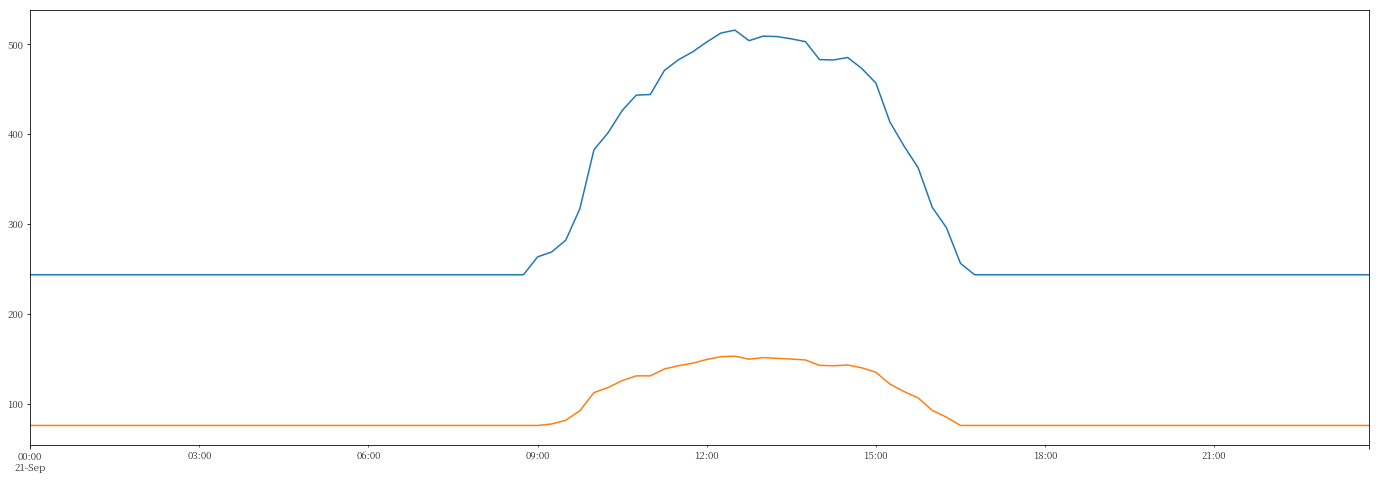

In [48]:
oid_ls = ['15481140757200897', '15481140757135361']
df_pred_new = post_pro_hand(oid_list=oid_ls, max_value_ls=[516, 153], df_pred=df_pred)
df_pred_new.loc[df_pred_new['oid']=='15481140757200897', 'y_pred'].plot(figsize=(24, 8))
df_pred_new.loc[df_pred_new['oid']=='15481140757135361', 'y_pred'].plot(figsize=(24, 8))

100%|██████████| 2/2 [00:02<00:00,  1.36s/it]


In [84]:
df['loc'] = df[['jd', 'wd']].apply(tuple, axis=1)
df_ls_shift = []
df_ls = []
for loc, value in df.groupby('loc'):
    df_ls_shift.append(value['pjfs2fz'].shift(96).rename('{}_lag{}'.format('pjfs2fz', i)))
    df_ls.append(value['pjfs2fz'])
        

In [62]:
import glob
import catboost as cb
model_path = 'test_his/center_jiutian/2023-09-09'
df_ls = []
oid_list = ['15481140756807681','15481140756873217','15481140756938753','15481140830863361','15481140766113793',
            '15481140766179329','15481140766244865','15481140766310401','15481140757266433','15481140757725185',
            '15481140757790721','15481140757004289','15481140757069825','15481140757135361','15481140757200897',
            '15481140766375937','15481140766441473','15481140766507009','15481140766572545','15481137326915585',
            '15481130476634115','15481130500882435','15481125255184390','15481129194225670','15481128900034564',
            '15481128891252742','15481130821025794','15481130821156866','15481130901110786','15481131802034178']
oid_list = sorted(oid_list)
for idx, model_file in enumerate(glob.glob(os.path.join(model_path, 'windmodel*'))):
    model = cb.CatBoostRegressor()
    model.load_model(model_file)
    feau_impo = model.get_feature_importance()
    feau_name = model.feature_names_
    df_ = pd.DataFrame({'name_{}'.format(oid_list[idx]):feau_name, 'impo':feau_impo})
    df_ = df_.sort_values('impo', ascending=False)
    df_.reset_index(drop=True, inplace=True)
    df_ls.append(df_)
#     break
df = pd.concat(df_ls, axis=1)
df.to_csv('analyzise/test/model_impo.csv')

In [60]:
df.head(10)

,name_15481125255184390,impo,name_15481128891252742,impo,name_15481128900034564,impo,name_15481129194225670,impo,name_15481130476634115,impo,...,name_15481140766375937,impo,name_15481140766441473,impo,name_15481140766507009,impo,name_15481140766572545,impo,name_15481140830863361,impo
0,total_radiation_109.133_21.45,10.583707,total_radiation_105.483_25.117,8.439780,num_samples,30.965680,num_samples,14.205440,num_samples,4.253446,...,ten_meter_wind_speed_109.05_19.27,18.651289,hour_cos,8.937942,one_hundred_wind_speed_110.75_19.62,3.252812,total_radiation_110.25_20.0,30.303014,one_hundred_wind_speed_109.17_18.75,2.838711
1,total_radiation_109.55_22.267,7.823607,total_radiation_105.183_25.433,6.904878,one_hundred_wind_speed_106.764_25.429,3.941405,one_hundred_wind_speed_110.5_24.767,13.071004,one_hundred_wind_speed_109.133_21.45,4.013631,...,num_samples,9.308633,total_radiation_109.133_21.45,7.115655,one_hundred_wind_speed_105.289_27.298,2.558793,total_radiation_110.165_20.243,7.054348,one_hundred_wind_speed_109.52_18.77,2.301075
2,total_radiation_110.165_20.243,5.745096,total_radiation_104.528_25.751,6.781126,one_hundred_wind_speed_106.728_26.59,1.049780,one_hundred_wind_speed_110.633_24.65,4.058730,ten_meter_wind_speed_109.133_21.45,3.814712,...,one_hundred_wind_speed_109.05_19.27,7.815877,total_radiation_109.57_18.22,6.815650,ten_meter_wind_speed_112.773_21.736,1.901992,hour_cos,5.122003,ten_meter_wind_speed_109.43_19.23,1.970848
3,hour_cos,3.269503,total_radiation_103.328_23.444,3.493403,ten_meter_wind_direction_110.33_18.8,0.950658,one_hundred_wind_speed_109.7_23.983,1.523282,one_hundred_wind_speed_109.183_21.667,2.459389,...,ten_meter_wind_speed_109.43_19.23,2.093161,total_radiation_110.165_20.243,6.146331,ten_meter_wind_speed_105.289_27.298,1.291332,total_radiation_110.3_25.317,3.884050,ten_meter_wind_speed_109.52_18.77,1.927767
4,total_radiation_110.25_20.0,3.092824,total_radiation_106.083_25.183,3.479089,one_hundred_meter_wind_direction_115.276_24.114,0.876240,one_hundred_wind_speed_109.667_23.6,1.517809,one_hundred_wind_speed_112.773_21.736,2.168869,...,ten_meter_wind_speed_109.52_18.77,1.627071,total_radiation_108.667_26.967,5.239117,ten_meter_wind_speed_110.33_18.8,0.913333,total_radiation_109.55_22.267,3.570909,one_hundred_wind_speed_109.1_21.033,1.813326
5,total_radiation_109.57_18.22,2.722120,total_radiation_109.57_18.22,3.416876,hour_cos,0.856625,one_hundred_wind_speed_107.55_24.983,1.441040,ten_meter_wind_speed_112.773_21.736,2.011010,...,one_hundred_wind_speed_109.17_18.75,1.429656,total_radiation_109.58_19.52,4.362018,ten_meter_wind_direction_113.009_23.145,0.872767,total_radiation_111.978_21.845,3.248211,ten_meter_wind_speed_109.1_21.033,1.732648
6,total_radiation_110.068_20.962,2.302434,total_radiation_101.663_26.038,2.977194,one_hundred_meter_wind_direction_107.95_21.567,0.830159,one_hundred_wind_speed_109.1_21.033,1.319058,one_hundred_wind_speed_107.95_21.567,1.997250,...,ten_meter_wind_direction_100.965_22.787,1.221016,total_radiation_110.25_20.0,4.097770,one_hundred_wind_speed_112.773_21.736,0.855594,total_radiation_109.58_19.52,2.557497,ten_meter_wind_direction_112.475_22.991,1.560336
7,total_radiation_111.787_22.164,2.175834,total_radiation_102.653_25.008,2.559422,one_hundred_wind_speed_114.927_24.448,0.801077,one_hundred_wind_speed_109.4_25.233,1.196997,ten_meter_wind_speed_107.95_21.567,1.901200,...,one_hundred_wind_speed_110.33_18.8,1.046469,total_radiation_111.787_22.164,3.198825,one_hundred_meter_wind_direction_109.52_18.77,0.848819,total_radiation_109.57_18.22,2.258169,ten_meter_wind_speed_109.17_18.75,1.560296
8,total_radiation_110.3_25.317,1.639890,num_samples,2.508551,total_radiation_100.177_25.708,0.796974,one_hundred_wind_speed_107.88_25.41,1.157096,ten_meter_wind_direction_110.989_21.546,1.733862,...,ten_meter_wind_speed_109.83_19.03,0.773089,total_radiation_109.55_22.267,2.555365,ten_meter_wind_direction_106.233_27.467,0.827644,total_radiation_111.787_22.164,1.102868,one_hundred_wind_speed_1

In [2]:
import glob
import catboost as cb
model_path = 'test_his/center_jiutian/2023-09-27'
df_ls = []
oid_list = ['15481140756807681','15481140756873217','15481140756938753','15481140830863361','15481140766113793',
            '15481140766179329','15481140766244865','15481140766310401','15481140757266433','15481140757725185',
            '15481140757790721','15481140757004289','15481140757069825','15481140757135361','15481140757200897',
            '15481140766375937','15481140766441473','15481140766507009','15481140766572545','15481137326915585',
            '15481130476634115','15481130500882435','15481125255184390','15481129194225670','15481128900034564',
            '15481128891252742','15481130821025794','15481130821156866','15481130901110786','15481131802034178']
oid_list = sorted(oid_list)
for oid in oid_list:
    model = cb.CatBoostRegressor()
    model.load_model(model_path+oid)
    feau_impo = model.get_feature_importance()
    feau_name = model.feature_names_
    df_ = pd.DataFrame({'name_{}'.format(oid):feau_name, 'impo':feau_impo})
    df_ = df_.sort_values('impo', ascending=False)
    df_.reset_index(drop=True, inplace=True)
    df_ls.append(df_)
#     break
df = pd.concat(df_ls, axis=1)
df.to_csv('analyzise/test/model_impo1.csv')

In [4]:
df.head()

,name_15481125255184390,impo,name_15481128891252742,impo,name_15481128900034564,impo,name_15481129194225670,impo,name_15481130476634115,impo,...,name_15481140766375937,impo,name_15481140766441473,impo,name_15481140766507009,impo,name_15481140766572545,impo,name_15481140830863361,impo
0,num_samples,8.715323,num_samples,10.753118,num_samples,19.807376,one_hundred_wind_speed_110.98166666666665_24.9...,9.330772,one_hundred_wind_speed_114.20034467514046_22.1...,3.430637,...,num_samples,7.734863,num_samples,5.761392,num_samples,7.807285,num_samples,12.055546,num_samples,7.136501
1,total_radiation_110.51768388074885_21.40020794...,2.218202,total_radiation_105.03916666666666_26.70027777...,4.733715,one_hundred_wind_speed_105.6093096045233_26.54...,6.793025,one_hundred_wind_speed_110.98166666666665_24.9...,5.188581,ten_meter_wind_direction_113.19970549750839_24...,3.252961,...,ten_meter_wind_speed_109.09779444444445_19.633...,6.253968,total_radiation_110.02908124999999_19.93001249...,4.164858,one_hundred_wind_speed_108.3849_18.4925_cub,1.057807,total_radiation_110.92605087719299_19.72175146...,5.231707,one_hundred_meter_wind_direction_111.523997777...,3.272475
2,total_radiation_110.92605087719299_19.72175146...,2.094033,total_radiation_107.12160226592789_25.49100120...,3.258335,hour_cos,5.620042,hour_cos,5.009983,one_hundred_wind_speed_114.20034467514046_22.1...,3.242813,...,ten_meter_wind_speed_109.09779444444445_19.633...,3.685298,total_radiation_110.92605087719299_19.72175146...,3.551385,one_hundred_meter_wind_direction_108.616666666...,1.037803,time_96,3.078802,one_hundred_meter_wind_direction_114.200344675...,2.953834
3,total_radiation_110.02908124999999_19.93001249...,1.932280,total_radiation_110.92605087719299_19.72175146...,3.174233,one_hundred_wind_speed_105.6093096045233_26.54...,4.328413,ten_meter_wind_speed_110.43337210223969_25.246...,4.309010,num_samples,3.147810,...,one_hundred_wind_speed_109.09779444444445_19.6...,3.522572,total_radiation_110.22114814814815_19.65550370...,3.248238,one_hundred_meter_wind_direction_108.3849_18.4925,1.029320,hour_sin,2.941368,one_hundred_meter_wind_direction_108.3849_18.4925,2.421539
4,total_radiation_108.97561136914081_23.02124609...,1.864194,total_radiation_105.5015050347196_26.155979379...,2.896077,ten_meter_wind_direction_100.131625_26.0833333...,2.903269,one_hundred_wind_speed_110.98166666666665_24.9...,3.866369,ten_meter_wind_speed_116.54965262904254_23.261...,2.762160,...,one_hundred_wind_speed_109.09779444444445_19.6...,2.356307,total_radiation_109.58221048800662_19.67278795...,3.222766,ten_meter_wind_direction_110.71666666666667_21...,0.973671,total_radiation_110.92605087719299_19.72175146...,2.527837,one_hundred_wind_speed_112.39832708337073_21.4...,1.931419


In [7]:
df_ = pd.read_pickle('test_his/center_jiutian_v1/2023-09-13/df_radi_align.p')

In [8]:
df_.columns

Index(['total_radiation_112.17277778_21.86152778',
       'total_radiation_105.33296202_25.54534214',
       'total_radiation_108.97561137_23.02124609',
       'total_radiation_107.3115517_25.70025571',
       'total_radiation_104.1151098_27.03315639',
       'total_radiation_108.01967665_23.36920491',
       'total_radiation_107.15725883_23.79042896',
       'total_radiation_110.071735_20.50337897',
       'total_radiation_108.98458472_23.27013899',
       'total_radiation_108.45_22.5',
       'total_radiation_108.51164934_22.2077458',
       'total_radiation_109.338961_24.70005353',
       'total_radiation_108.28841454_22.42751476',
       'total_radiation_108.18319727_21.99522893',
       'total_radiation_108.48770111_21.89724204',
       'total_radiation_109.75940198_23.06730766',
       'total_radiation_105.44961732_26.8292439',
       'total_radiation_105.19633738_26.17116918',
       'total_radiation_110.51768388_21.40020795',
       'total_radiation_108.8398241_18.66888701',
  

In [90]:
pd.concat(df_ls, axis=1).head()

,pjfs2fz,pjfs2fz,pjfs2fz,pjfs2fz,pjfs2fz,pjfs2fz,pjfs2fz,pjfs2fz,pjfs2fz,pjfs2fz,...,pjfs2fz,pjfs2fz,pjfs2fz,pjfs2fz,pjfs2fz,pjfs2fz,pjfs2fz,pjfs2fz,pjfs2fz,pjfs2fz
zlsc,,,,,,,,,,,,,,,,,,,,,
2023-08-01 00:00:00+08:00,1.7,1.5,0.7,0.4,1.0,0.0,0.6,0.6,0.7,0.8,...,1.2,1.6,1.4,1.8,1.1,1.2,0.6,1.7,1.6,1.3
2023-08-01 00:15:00+08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-08-01 00:30:00+08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-08-01 00:45:00+08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-08-01 01:00:00+08:00,1.0,0.8,0.5,0.7,1.0,1.0,0.3,0.0,0.1,0.8,...,1.4,1.3,1.0,2.2,0.9,1.1,0.8,1.6,1.4,1.2
